In [266]:
import pandas as pd
import numpy as np
import folium
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [267]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

Poznámka: nepodarilo sa mi zohnať jednoznačné členenie a pomenovanie cyklotrás v Bratislave, preto vo väčšíne prípadov budem predpokladať, že jeden sčítač reprezentuje jednu cyklotrasu. Tiež došlo k istému rozdvojeniu datasetov, preto tu opakujem niektoré časti zo spracovania dát.

In [268]:
path = '/content/cyklotrasy_data_bratislava_raw.csv' if IN_COLAB else '../Data/cyklotrasy_data_bratislava_raw.csv'
df = pd.read_csv(path)

# skopirovane z spracovanie_dat.ipynb ale bez weather_data
df["datetime"] = (
    pd.to_datetime(df["attributes.DATUM_A_CAS"], utc=True)
      .dt.tz_convert("Europe/Bratislava")
      .dt.tz_localize(None)
)

df = df.rename(columns={
    'attributes.NAZOV': 'nazov',
    'attributes.ZEMEPISNA_SIRKA': 'zemepisna_sirka',
    'attributes.ZEMEPISNA_DLZKA': 'zemepisna_dlzka',
    'attributes.SMER_DO': 'smer_do',
    'attributes.SMER_Z': 'smer_z',
    'attributes.POCET_DO': 'pocet_do',
    'attributes.POCET_Z': 'pocet_z'})

df = df.drop(columns=['attributes.ObjectId', 'attributes.DATUM_A_CAS'])

df["pocet_total"] = df["pocet_do"] + df["pocet_z"]
df["date"] = df["datetime"].dt.normalize()
df["weekday"] = df["datetime"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year

# niektore retazce koncili aj nekoncili na '\n'
# preto preventivne odstranit whitespace zo zaciatku a konca retazcov
string_columns = ['nazov', 'smer_do', 'smer_z']
for col in string_columns:
    df[col] = df[col].str.strip()

display(df[df.duplicated(subset=['nazov', 'datetime'])])
df = df.drop_duplicates(subset=['nazov', 'datetime'])

nazov  zemepisna_sirka  zemepisna_dlzka          smer_do  \
54194   #4 - Dolnozemská        48.112534        17.128937  Dunajská hrázda   
171084   #3 - River Park        48.139560        17.117371          Centrum   

                  smer_z  pocet_do  pocet_z            datetime  pocet_total  \
54194          Petržalka         0        0 2022-10-30 02:00:00            0   
171084  Most Lanfranconi        10       12 2022-10-30 02:00:00           22   

             date  weekday  is_weekend  month  year  
54194  2022-10-30        6           1     10  2022  
171084 2022-10-30        6           1     10  2022

In [269]:
df.describe()

zemepisna_sirka  zemepisna_dlzka       pocet_do        pocet_z  \
count    695734.000000    695734.000000  695734.000000  695734.000000   
mean         48.153007        17.074672      11.639934       7.928660   
min          48.110442        16.969000      -1.000000       0.000000   
25%          48.134661        17.068983       0.000000       0.000000   
50%          48.140495        17.106380       2.000000       1.000000   
75%          48.163253        17.117371      12.000000       6.000000   
max          48.210650        17.138556     583.000000     645.000000   
std           0.031301         0.060683      23.286795      19.899776   

                            datetime    pocet_total  \
count                         695734  695734.000000   
mean   2022-10-08 06:54:11.230499584      19.568594   
min              2014-07-18 09:00:00      -1.000000   
25%              2021-03-20 10:00:00       0.000000   
50%              2023-11-17 12:00:00       4.000000   
75%              2025-01-07 20:00:00      22.000000   
max              2025-12-26 00:00:00     852.000000   
std                              NaN      39.450822   

                                date        weekday     is_weekend  \
count                         695734  695734.000000  695734.000000   
mean   2022-10-07 19:24:05.590412288       2.999112       0.285526   
min              2014-07-18 00:00:00       0.000000       0.000000   
25%              2021-03-20 00:00:00       1.000000       0.000000   
50%              2023-11-17 00:00:00       3.000000       0.000000   
75%              2025-01-07 00:00:00       5.000000       1.000000   
max              2025-12-26 00:00:00       6.000000       1.000000   
std                              NaN       1.999687       0.451665   

               month           year  
count  695734.000000  695734.000000  
mean        6.711183    2022.251999  
min         1.000000    2014.000000  
25%         4.000000    2021.000000  
50%         7.000000    2023.000000  
75%        10.000000    2025.000000  
max        12.000000    2025.000000  
std         3.406927       3.000578

In [270]:
display(df[df['pocet_do'] < 0])
# display(df[(df['nazov'] == '#4 - Dolnozemská') & (df['date'] < '2022-10-09') & (df['date'] >= '2022-10-08')])
df.loc[df['pocet_do'] < 0, 'pocet_do'] = 0
df["pocet_total"] = df["pocet_do"] + df["pocet_z"]

nazov  zemepisna_sirka  zemepisna_dlzka          smer_do  \
55124  #4 - Dolnozemská        48.112534        17.128937  Dunajská hrázda   

          smer_z  pocet_do  pocet_z            datetime  pocet_total  \
55124  Petržalka        -1        0 2022-10-08 22:00:00           -1   

            date  weekday  is_weekend  month  year  
55124 2022-10-08        5           1     10  2022

# Zobrazenie sčítačov

In [271]:
def parse_counter_names_for_sorting(series: pd.Series) -> pd.Series:
    """
    Parse counter names like '#1 - Starý Most' for proper sorting.
    Returns a temporary Series that pandas can sort by.
    """
    def parse_single_name(name: str):
        if pd.isna(name):
            return (float('inf'), '')
        name_str = str(name)
        if '-' in name_str:
            parts = name_str.split('-', 1)
            num_part = parts[0].lstrip('#').strip()
            rest_part = parts[1].strip()
            num = int(num_part) if num_part.isnumeric() else float('inf')
            return (num, rest_part)
        return (float('inf'), name_str.strip())
    parsed = series.apply(parse_single_name)
    return parsed

unique_counters = (df[['nazov', 'smer_do', 'smer_z', 'zemepisna_sirka', 'zemepisna_dlzka']]
                   .drop_duplicates()
                   .sort_values(by=['nazov'], key=parse_counter_names_for_sorting)
                   .reset_index(drop=True))
unique_counters

nazov  \
0             #1 - Starý Most   
1           #2 - Starý most 2   
2             #3 - River Park   
3            #4 - Dolnozemská   
4         #5 - Devínska cesta   
5              #6 - Vajnorská   
6        #7 - Vajnorská > NTC   
7               #8 - Most SNP   
8              #9 - Páričkova   
9              #10 - Dunajská   
10          #11 - Most Apollo   
11    #12 - Železná studnička   
12         #13 - Vajanského 1   
13         #14 - Vajanského 2   
14  #15 - Incheba Einsteinova   
15          #16 - Trenčianska   
16  #17 - Dunajská/Lazaretská   
17          Cyklomost Slobody   
18          Devinska Nova Ves   
19                Hradza Berg   
20                  Viedenska   

                                            smer_do  \
0                                           Centrum   
1                                         Petržalka   
2                                           Centrum   
3                                   Dunajská hrázda   
4                                           Centrum   
5                                          Kuchajda   
6                           Trnavské mýto (Centrum)   
7                                         Petržalka   
8                                   Dulovo námestie   
9                        Centrum (Kamenné námestie)   
10                                          Centrum   
11                                     Ku studničke   
12                                         Most SNP   
13                              Šafárikovo námestie   
14                                      Einsteinova   
15                                       Miletičova   
16                                          Centrum   
17  Cyklomost Slobody Pedestrians IN - na Slovensko   
18                                        do Devína   
19                                     Do Slovenska   
20                                  k Staremu mostu   

                                              smer_z  zemepisna_sirka  \
0                                          Petržalka        48.110442   
1                                            Centrum        48.140042   
2                                   Most Lanfranconi        48.139560   
3                                          Petržalka        48.112534   
4                                              Devín        48.163253   
5                            Trnavské mýto (Centrum)        48.162144   
6                                           Kuchajda        48.162144   
7                                            Centrum        48.140495   
8                             Mlynské nivy (Centrum)        48.148070   
9                                       Mlynské nivy        48.144847   
10                                         Petržalka        48.134661   
11                                      Od studničky        48.176254   
12         NIE JE - v mieste je jednosmerná premávka        48.140819   
13         NIE JE - v mieste je jednosmerná premávka        48.140338   
14                                           Centrum        48.132484   
15                                   Dulovo Námestie        48.151117   
16                                      Mlynské nivy        48.145995   
17  Cyklomost Slobody Pedestrians OUT - zo Slovenska        48.210650   
18                            do Devínskej Novej Vsi        48.197826   
19                                        Do Rakuska        48.123215   
20                                       k Mostu SNP        48.136692   

    zemepisna_dlzka  
0         17.127512  
1         17.117292  
2         17.117371  
3         17.128937  
4         16.999958  
5         17.131644  
6         17.131644  
7         17.104856  
8         17.128182  
9         17.116058  
10        17.127928  
11        17.073272  
12        17.114909  
13        17.113438  
14        17.103304  
15        17.138556  
16        17.119804  
17        16.969000  
18        16.972652  
19        17.068983  
20        17.1063

In [272]:
def get_style_for_counter(counter_name):
    """
    Takes a counter name (nazov) and returns a tuple of (color, icon_name)
    based on the location group it belongs to.
    """
    counter_name_lower = str(counter_name).lower()

    if 'starý most' in counter_name_lower:
        return ('gray', 'bridge')
    elif 'vajnorská' in counter_name_lower:
        return ('purple', 'wine-bottle')
    elif 'vajanského' in counter_name_lower:
        return ('blue', 'water')
    elif 'dunajská' in counter_name_lower:
        return ('green', 'fish')
    return ('red', 'bicycle')

map_center = [df['zemepisna_sirka'].mean(), df['zemepisna_dlzka'].mean()]
my_map = folium.Map(location=map_center, zoom_start=12)

for _, row in unique_counters.iterrows():
    popup_html = f"""
        <b>{row['nazov']}</b><br>
        Smer do: {row['smer_do']}<br>
        Smer z: {row['smer_z']}<br>
        <i>Súradnice:</i>{row['zemepisna_sirka']:.6f}, {row['zemepisna_dlzka']:.6f}
    """
    color, icon = get_style_for_counter(row['nazov'])
    folium.Marker(
        location=[row['zemepisna_sirka'], row['zemepisna_dlzka']],
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=f"{row['nazov']} (klik pre viac info)",
        icon=folium.Icon(color=color, icon=icon, prefix='fa')
    ).add_to(my_map)
my_map

# # ak chceme ulozit mapu do HTML
# my_map.save('bratislava_bicycle_counters.html')
# print("Map saved as 'bratislava_bicycle_counters.html'")

In [273]:
point_1 = df.loc[df['nazov'] == '#13 - Vajanského 1',
                 ['zemepisna_sirka', 'zemepisna_dlzka']].values[0]
point_2 = df.loc[df['nazov'] == '#14 - Vajanského 2',
                 ['zemepisna_sirka', 'zemepisna_dlzka']].values[0]

distance_m = geodesic(point_1, point_2).m
print(f"Vzdialenosť medzi Vajanského sčítačmi: {distance_m:.1f} m")

Vzdialenosť medzi Vajanského sčítačmi: 121.9 m


Pri skúmaní koľko cyklotrás sa nachádza v datasete sme zistili, že je tam viacero sčítačov s rovnakými/podobnými názvami aj smermi, preto sme si ich zobrazili na mape aby sme prišli na to, či by bolo vhodné niektoré vylúčiť z ďalšej analýzy.
Pre cyklotrasy s rovnakým/podobným názvom sme zistili, že:
- v prípade **Starého mostu** sú sčítače umiestnené ďaleko od seba, preto ich budeme počítať osobitne,
- u **Vajnorskej** sú sčítače na rovnakom mieste, preto je potrebná ďalšia analýza na zistenie ďalšieho postupu,
- pri **Vajanského** sú sčítače na opačných stranách cesty pre autá, vzdialené iba 122 metrov a každý počíta premávku iba jedným smerom, preto tieto v datasete zlúčime, aby sme mali jeden obojsmerný sčítač pre túto trasu.

Tiež sme si všimli, že sčítače **Starý most 1** a **Dolnozemská**, **Starý most 2** a **River Park**, **Dunajská** a **Dunajská/Lazaretská** sú blízko pri sebe, preto sa tiež pozrieme, či nemajú prevažne rovnaké počty a či nie sú silno korelované.

## Kontrola korelácie pre blízke sčítače

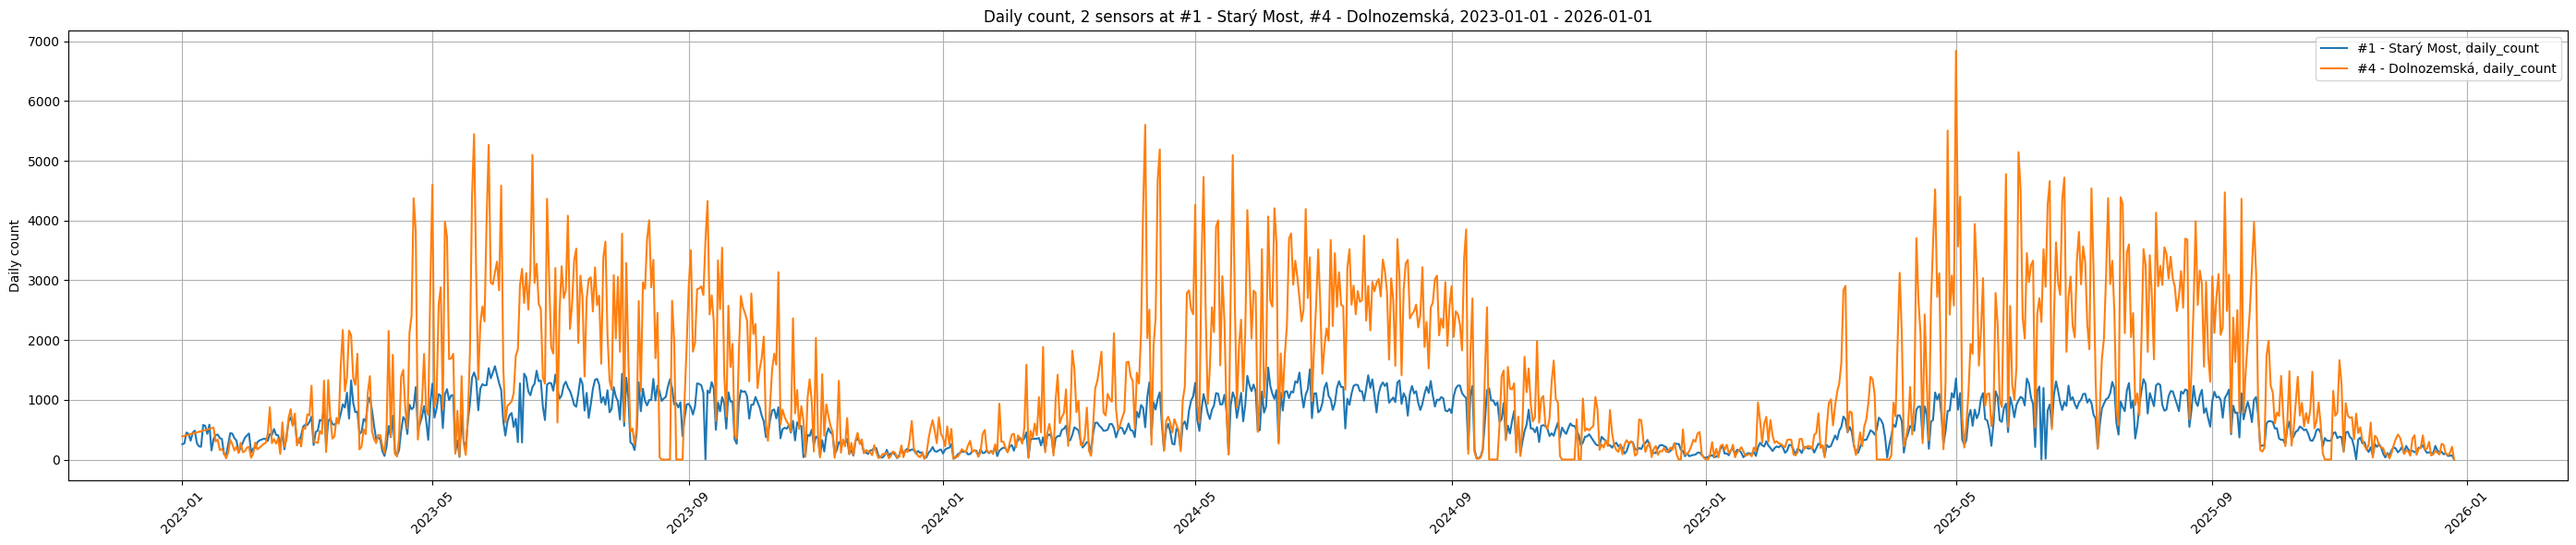

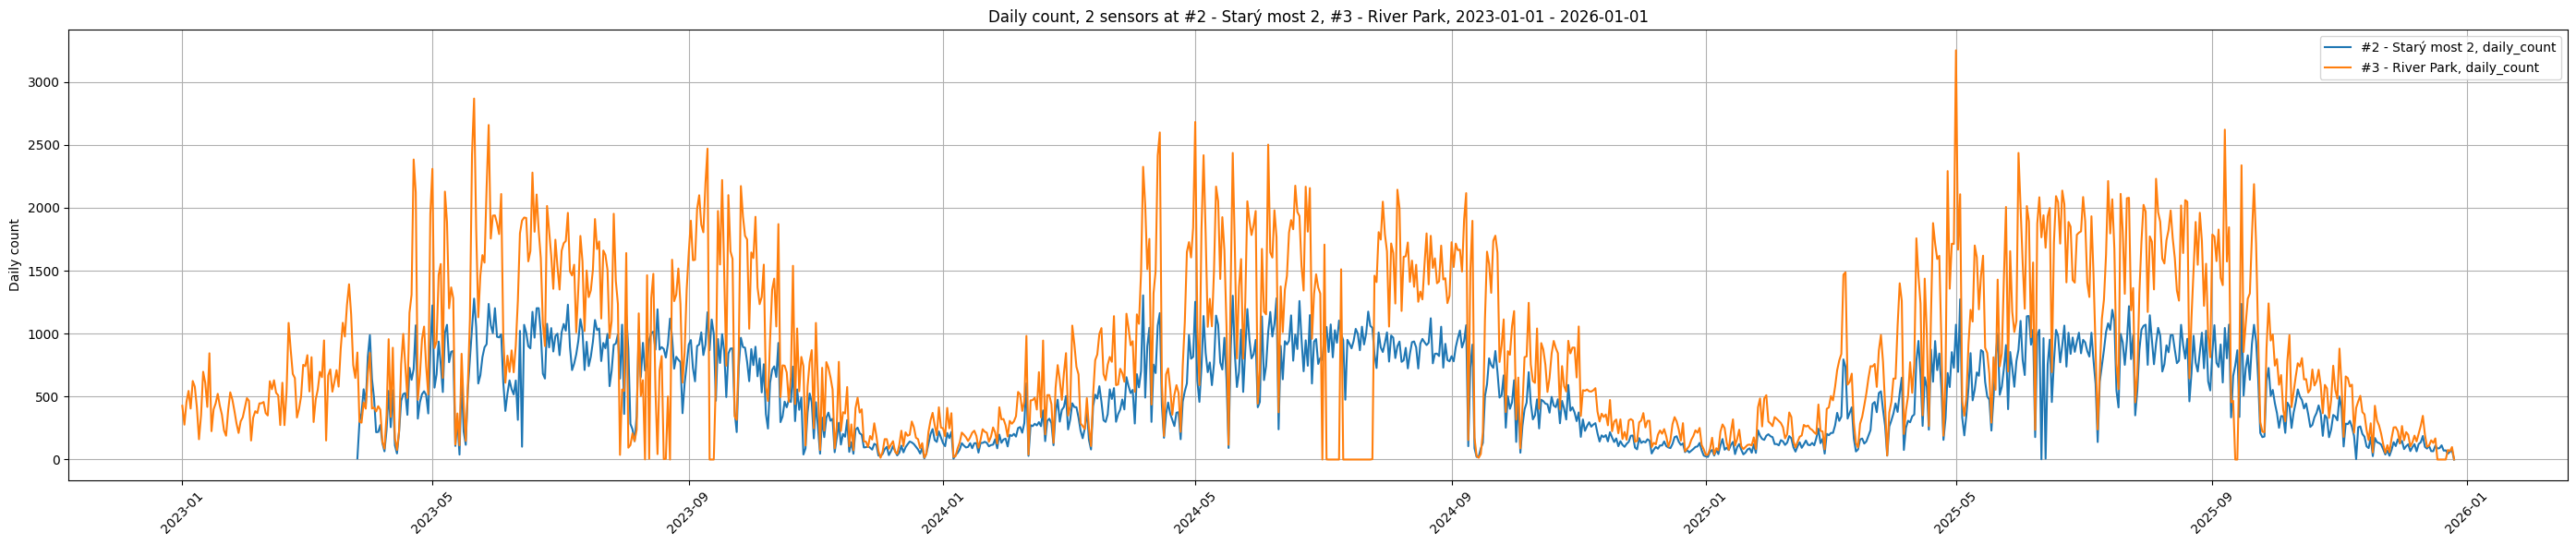

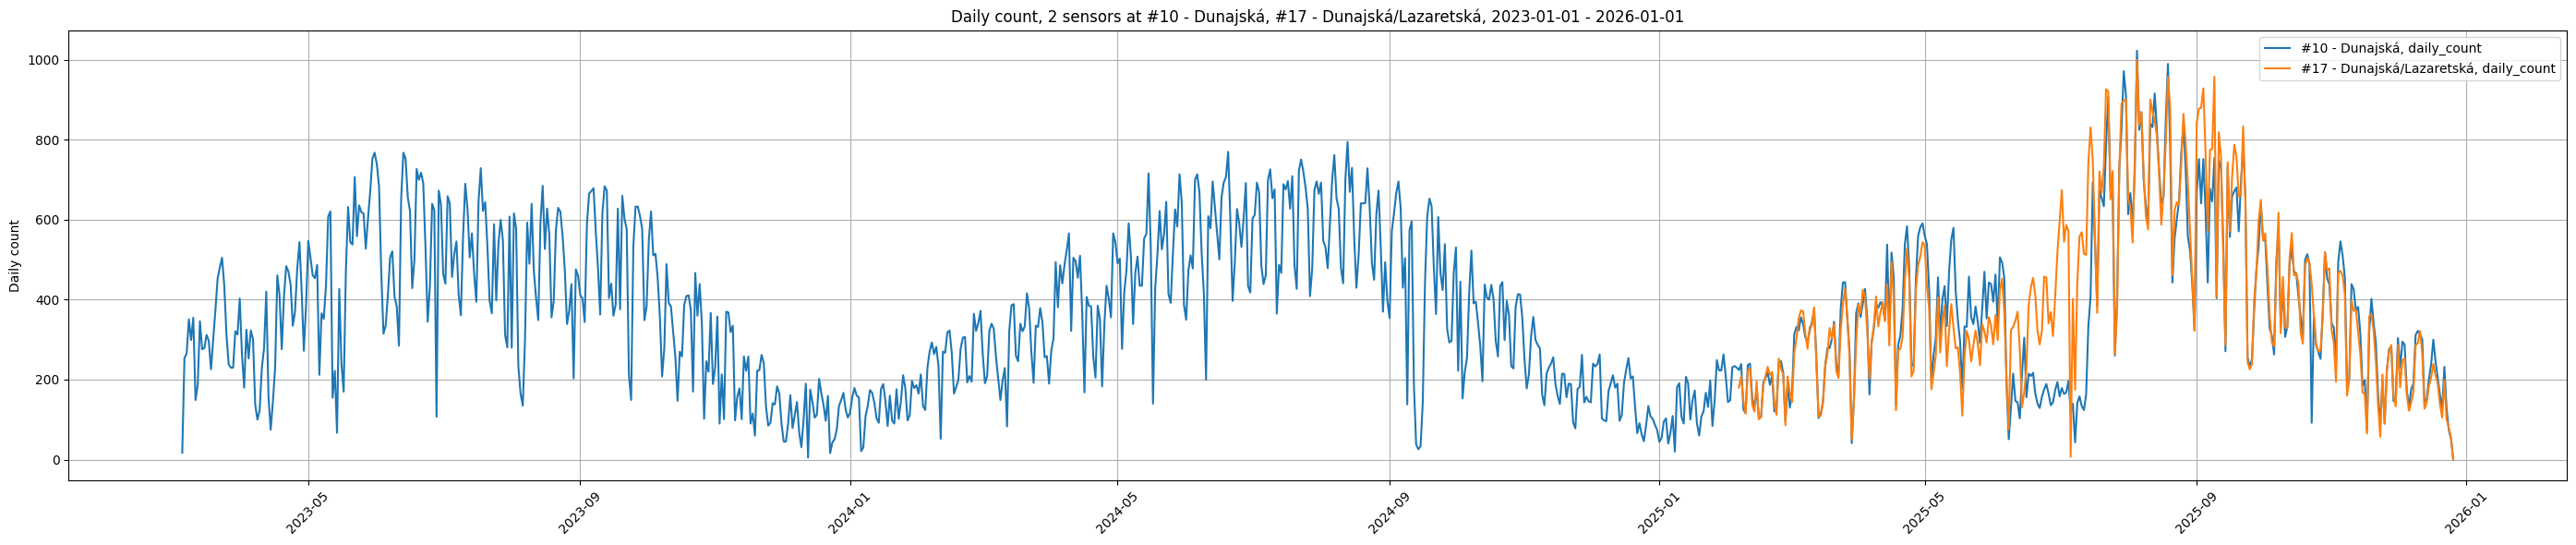

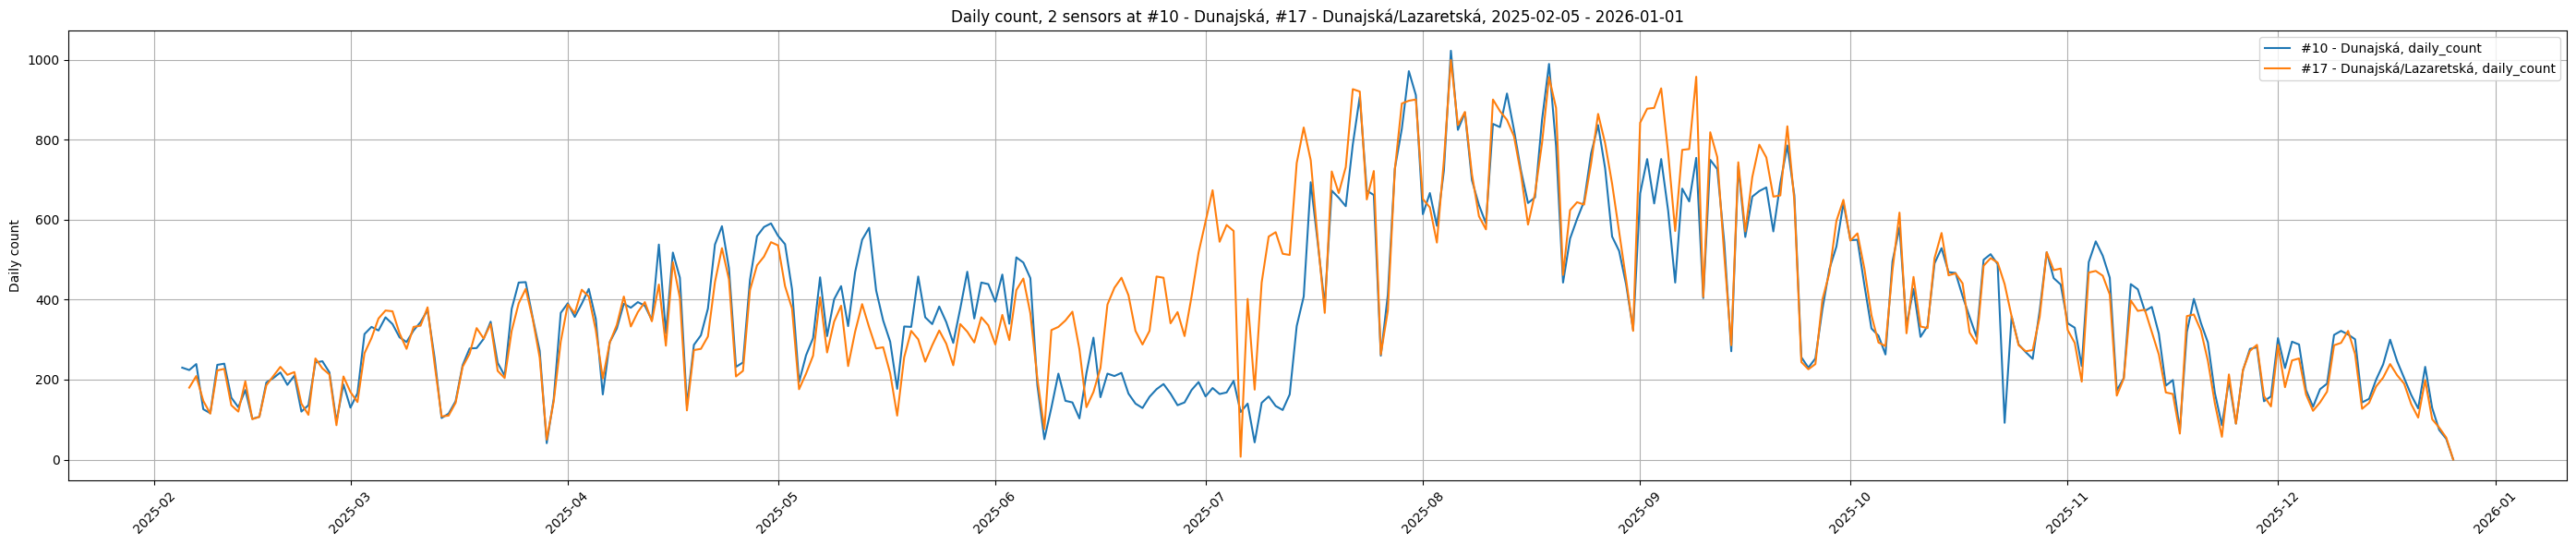

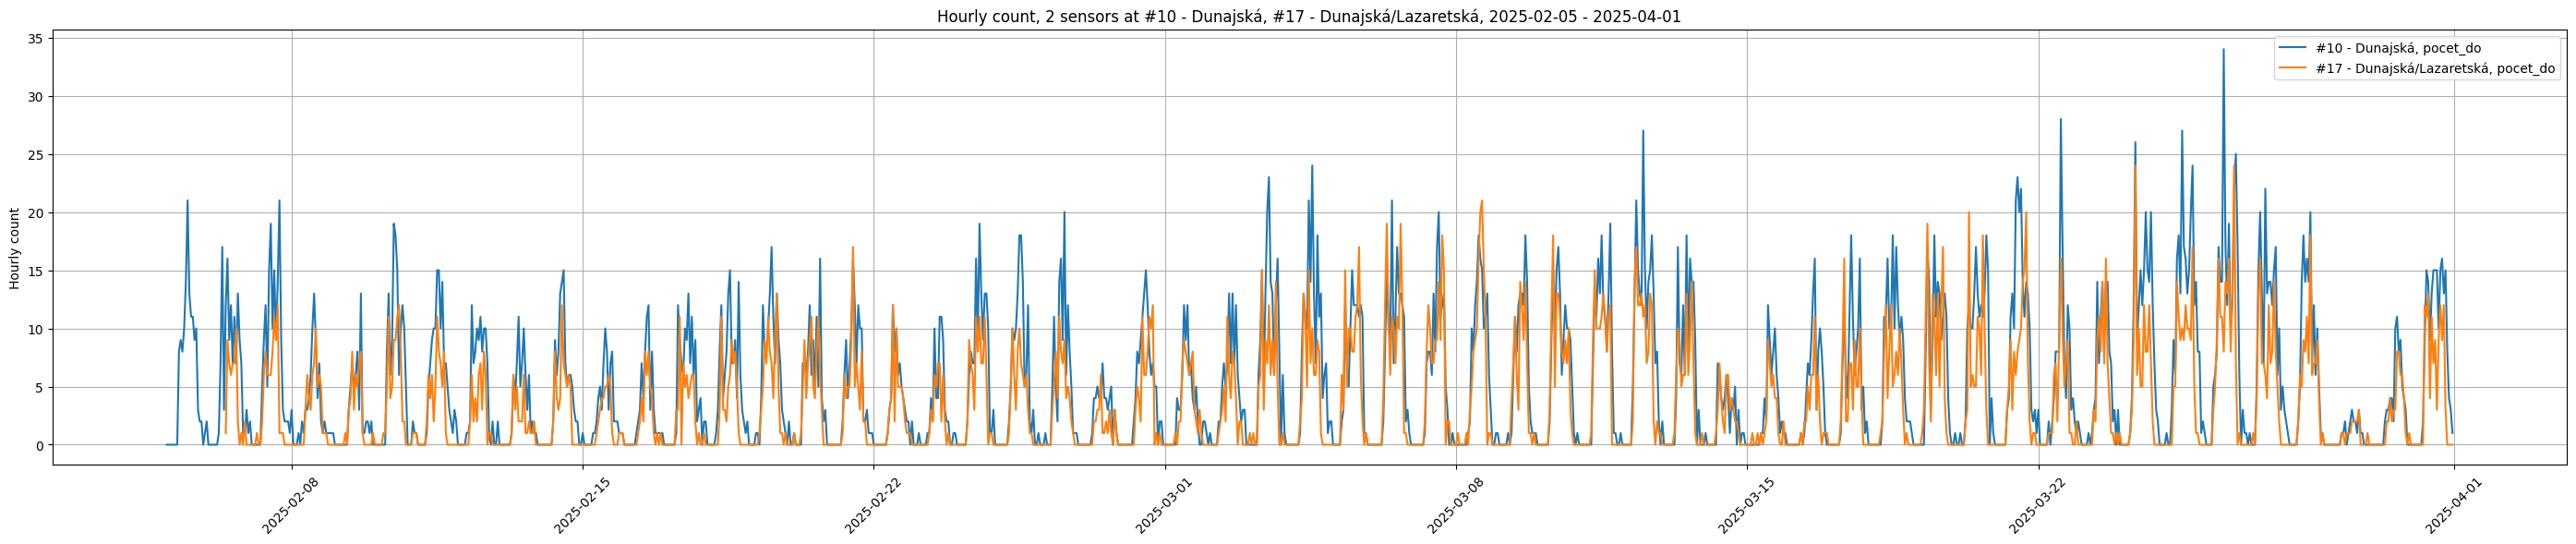

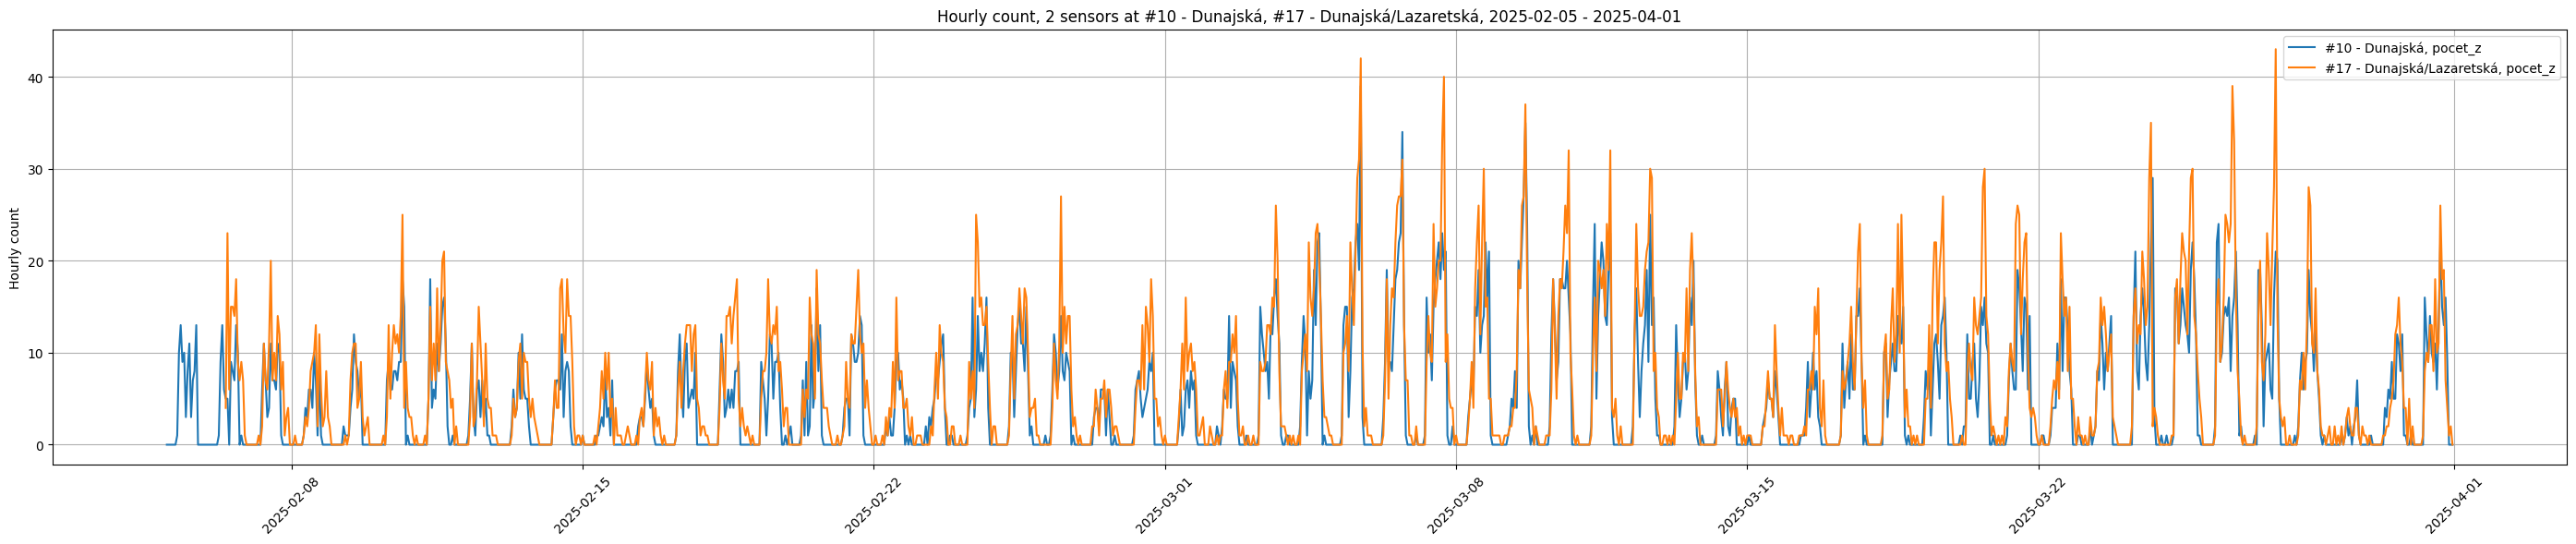

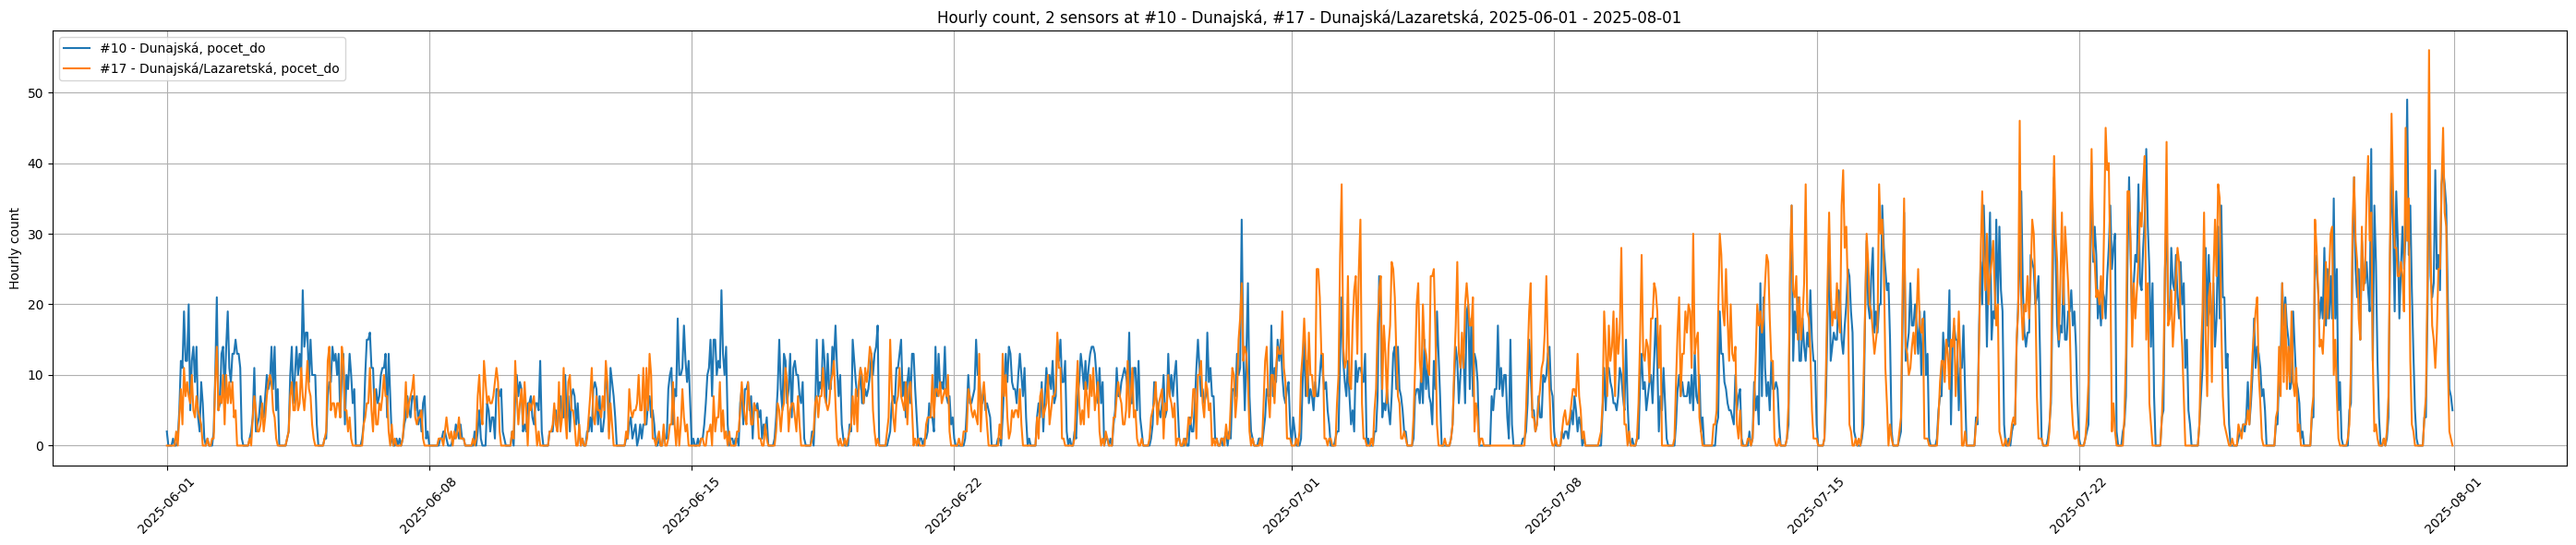

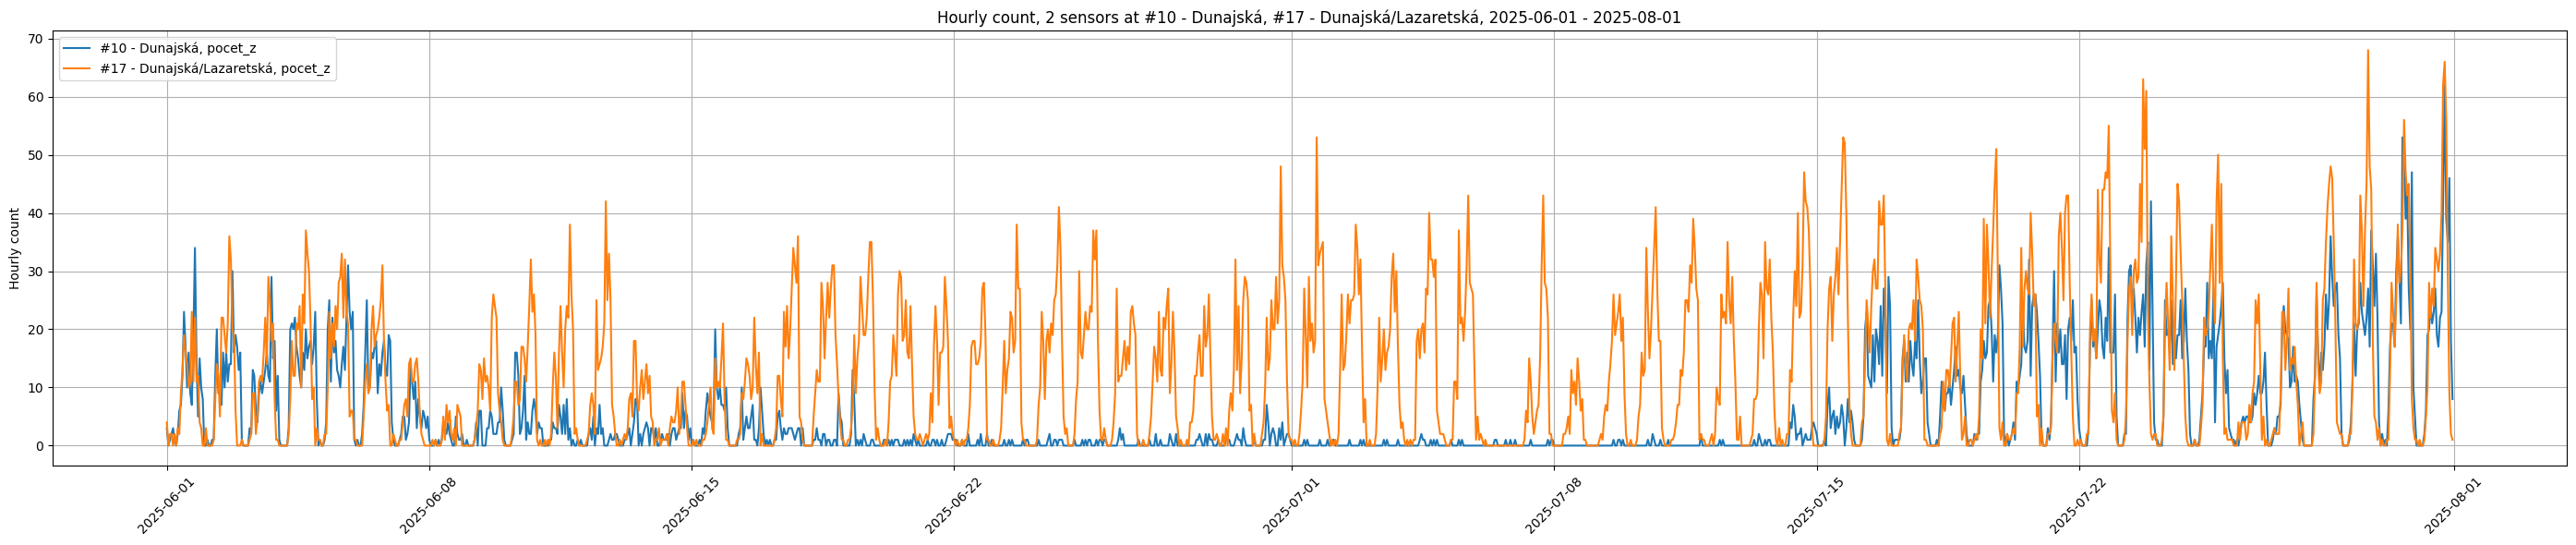

In [274]:
def plot_data_at_route(data, start_date, end_date, counter_names, counts, y_title):
    """
    Plots time series data for specified bicycle counter routes and metrics.
    This function filters a DataFrame for given routes and a date range,
    sorts the data chronologically, and generates a line plot for each
    combination of route and count metric. It automatically handles both
    hourly ('datetime') and daily ('date') temporal data.
    """
    date_range = (data['date'] >= start_date) & (data['date'] < end_date)
    routes_hourly = [data[(data['nazov'] == route) & date_range] for route in counter_names]
    time_unit = 'datetime' if 'datetime' in data.columns else 'date'

    plt.figure(figsize=(28, 6))
    for route_name, route in zip(counter_names, routes_hourly):
        for count in counts:
            sorted_route = route.sort_values(time_unit)
            plt.plot(sorted_route[time_unit], sorted_route[count],
                     label=f'{route_name}, {count}')
    plt.xticks(rotation=45)
    plt.ylabel(y_title)
    routes_string = ', '.join(counter_names)
    plt.title(f'{y_title}, {len(counter_names)} sensors at {routes_string}, {start_date} - {end_date}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

daily_counts = (df.groupby(['nazov', 'date'])['pocet_total'].sum()
    .reset_index(name='daily_count')
)
names = ['#1 - Starý Most', '#4 - Dolnozemská']
plot_data_at_route(daily_counts, '2023-01-01', '2026-01-01', names, ['daily_count'], 'Daily count')

names = ['#2 - Starý most 2', '#3 - River Park']
plot_data_at_route(daily_counts, '2023-01-01', '2026-01-01', names, ['daily_count'], 'Daily count')

names = ['#10 - Dunajská', '#17 - Dunajská/Lazaretská']
plot_data_at_route(daily_counts, '2023-01-01', '2026-01-01', names, ['daily_count'], 'Daily count')
plot_data_at_route(daily_counts, '2025-02-05', '2026-01-01', names, ['daily_count'], 'Daily count')
plot_data_at_route(df, '2025-02-05', '2025-04-01', names, ['pocet_do'], 'Hourly count')
plot_data_at_route(df, '2025-02-05', '2025-04-01', names, ['pocet_z'], 'Hourly count')
plot_data_at_route(df, '2025-06-01', '2025-08-01', names, ['pocet_do'], 'Hourly count')
plot_data_at_route(df, '2025-06-01', '2025-08-01', names, ['pocet_z'], 'Hourly count')

Z grafov vidíme, že v prípadoch **Starého mostu 1** a **Dolnozemskej**, **Starého mostu 2** a **River Parku** majú sčítače dostatočne odlišné počty aby sa oplatilo ponechať ich údaje, no v prípade **Dunajskej** a **Dunajskej/Lazaretskej** nielenže druhý sčítač začal počítať až niekedy vo februári 2025, takže má omnoho kratší časový rozsah, ale je jeho hodnoty sú väčšínu času silno korelované s prvým sčítačom. Na druhú stranu, je tam niekoľkotýždňové obdobie, kedy sa ich počty veľmi líšia, preto necháme obidva sčítače v datasete.

## Vajanského

Na počudovanie napriek tomu, že smer_z je pre obidva sčítače na Vajanského nábreží označený ako 'NIE JE - v mieste je jednosmerná premávka', zdá sa, že sčítače majú aj v tomto zakázanom smere väčšinu dní nenulové počty, pre niektoré hodiny dokonca prevyšujú počty v legálnom smere. Bohužiaľ nemáme dosť údajov aby sme vedeli jednoznačne určiť, či išlo o poruchu alebo nepresnosť sčítačov, alebo či naozaj tak veľa cyklistov porušuje cestný poriadok, alebo či sčítače počítali aj iné objekty, ktoré snáď majú povolenie ísť v protismere. Pri zlučovaní týchto dvoch sčítačov sme sa rozhodli tieto ilegálne hodnoty ignorovať.

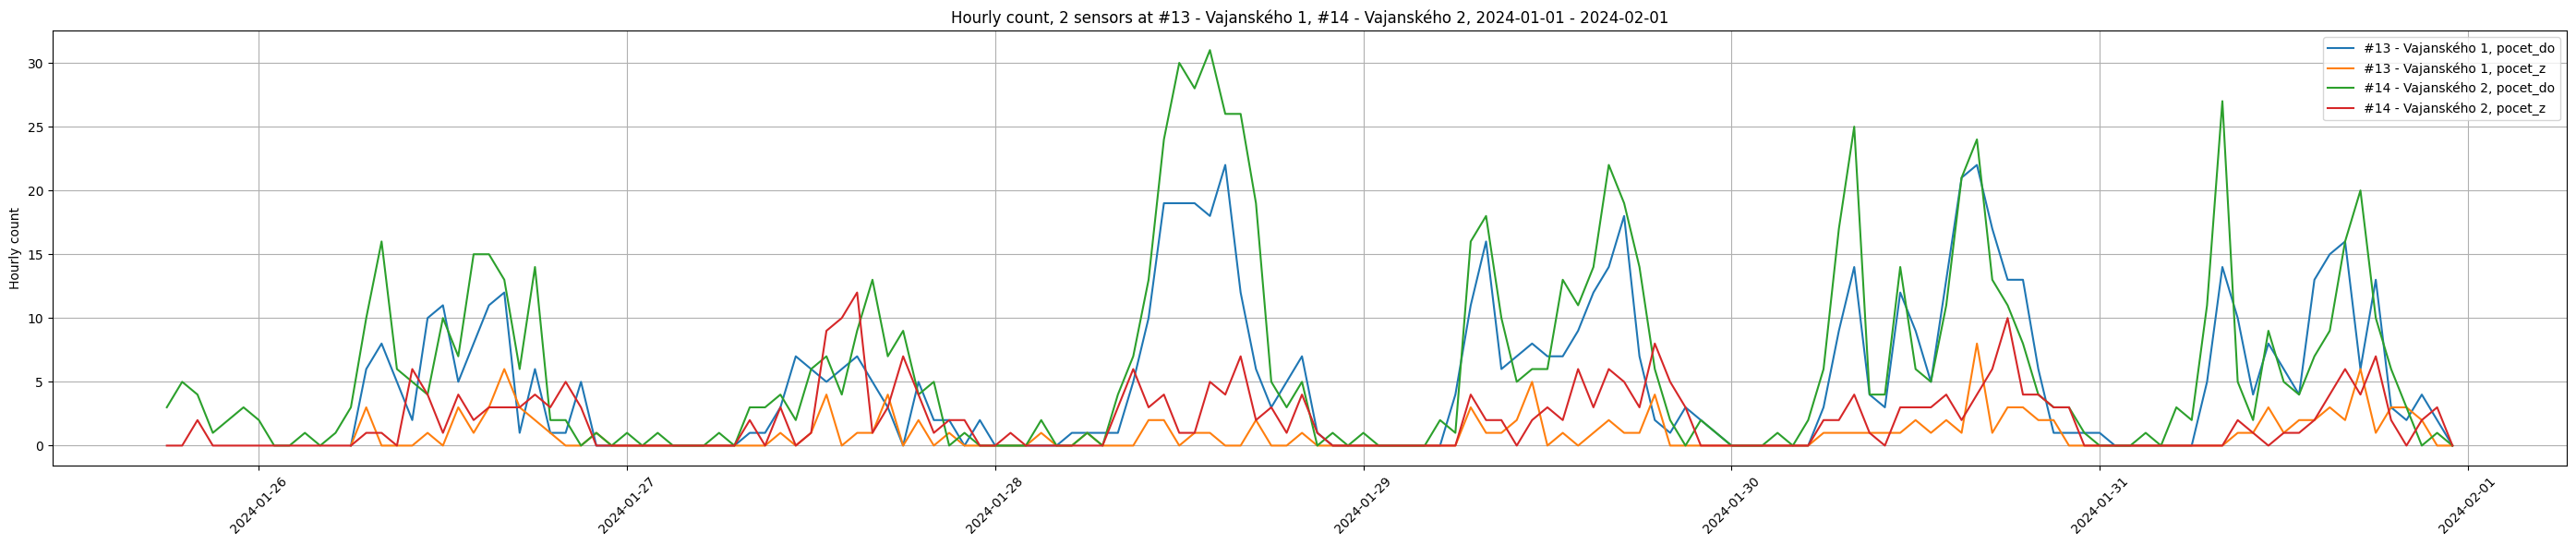

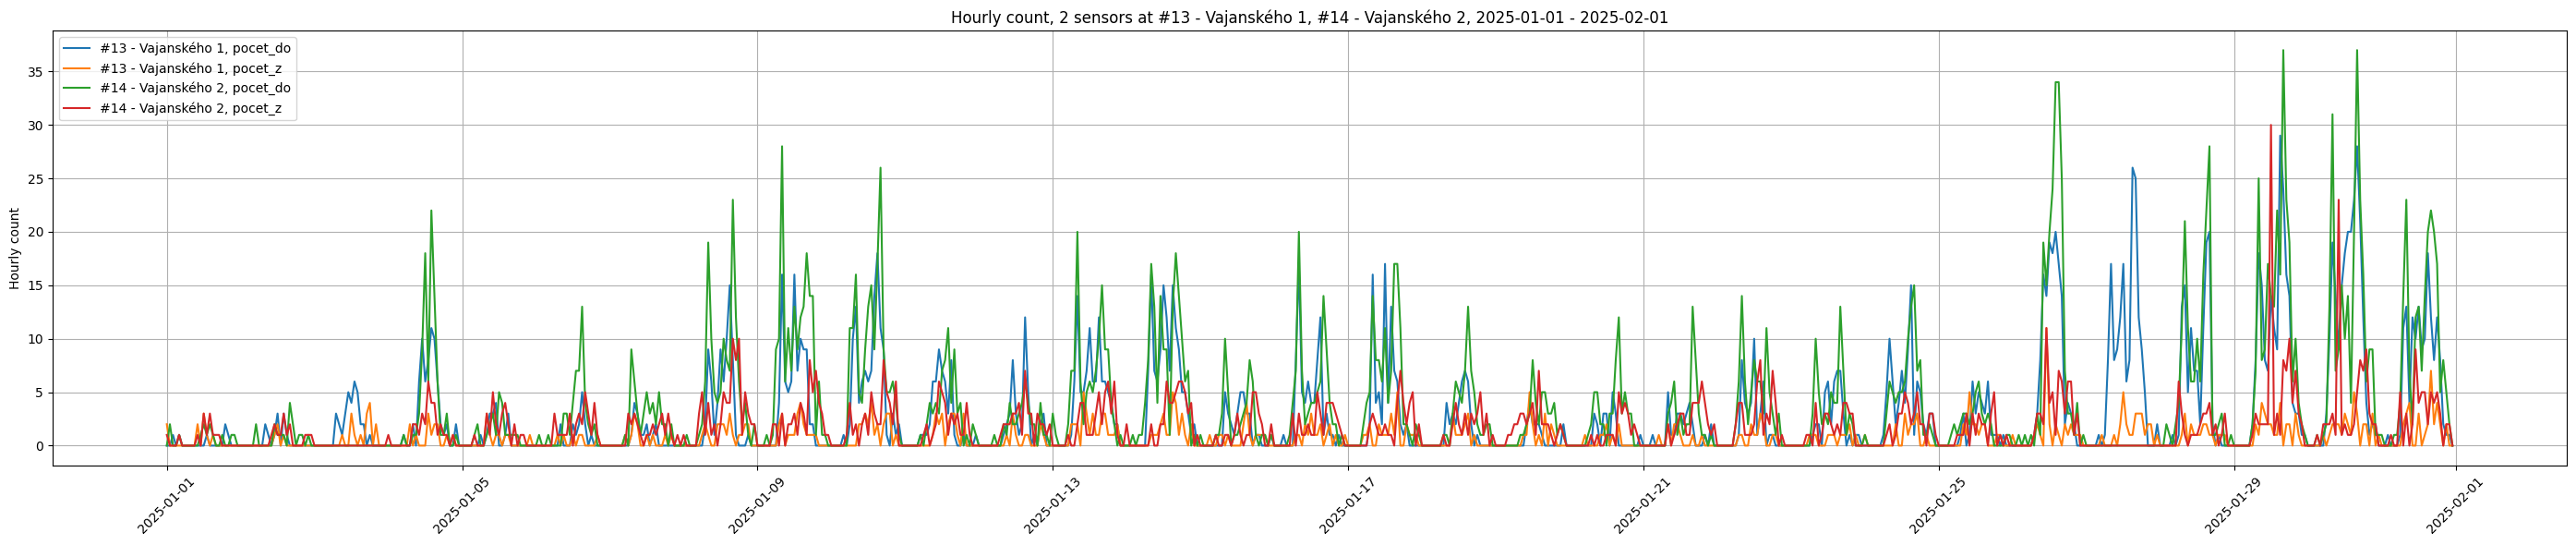

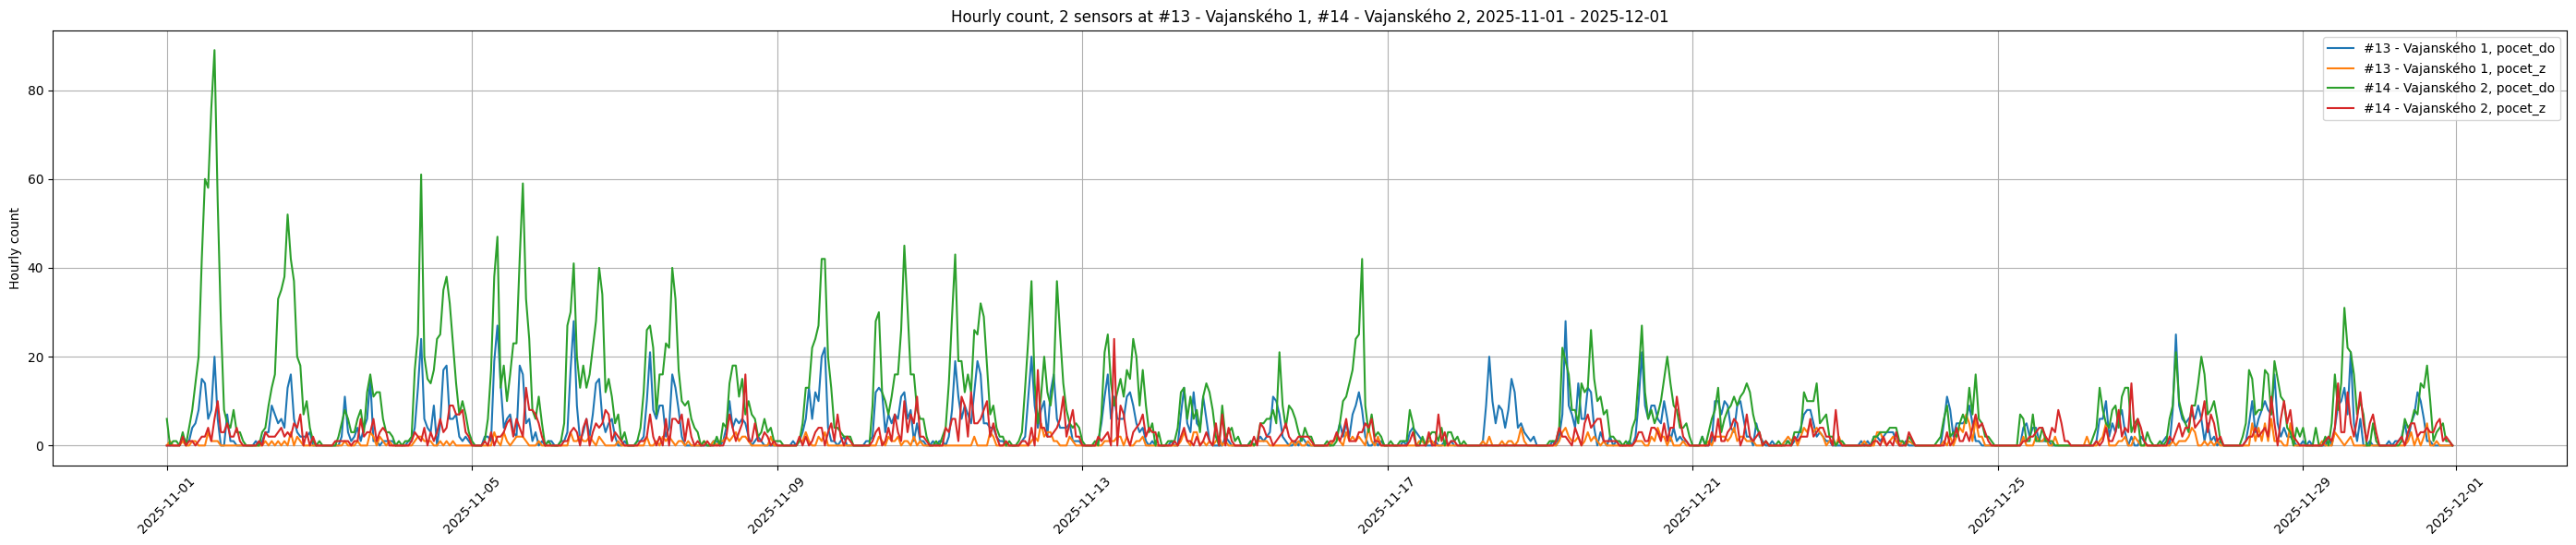

In [275]:
names = ['#13 - Vajanského 1', '#14 - Vajanského 2']
plot_data_at_route(df, '2024-01-01', '2024-02-01', names, ['pocet_do', 'pocet_z'], 'Hourly count')
plot_data_at_route(df, '2025-01-01', '2025-02-01', names, ['pocet_do', 'pocet_z'], 'Hourly count')
plot_data_at_route(df, '2025-11-01', '2025-12-01', names, ['pocet_do', 'pocet_z'], 'Hourly count')

In [276]:
vajanskeho_1 = df[(df['nazov'] == '#13 - Vajanského 1')].copy()
vajanskeho_2 = df[(df['nazov'] == '#14 - Vajanského 2')].copy()
display(vajanskeho_1.shape)
display(vajanskeho_2.shape)
print('Start of monitoring:')
display(vajanskeho_1['datetime'].min())
display(vajanskeho_2['datetime'].min())
print('End of monitoring')
display(vajanskeho_1['datetime'].max())
display(vajanskeho_2['datetime'].max())

(16791, 14)

(16803, 14)

Start of monitoring:


Timestamp('2024-01-26 06:00:00')

Timestamp('2024-01-25 18:00:00')

End of monitoring


Timestamp('2025-12-26 00:00:00')

Timestamp('2025-12-26 00:00:00')

In [277]:
combined_df = pd.merge(
    vajanskeho_1,
    vajanskeho_2[['datetime', 'smer_do', 'pocet_do']].rename(
        columns={'smer_do': 'smer_z_combined', 'pocet_do': 'pocet_z_combined'}
    ),
    on='datetime',
    how='inner'
)

combined_df['nazov'] = 'Vajanského_combined'
combined_df['smer_z'] = combined_df['smer_z_combined']
combined_df['pocet_z'] = combined_df['pocet_z_combined']
combined_df['pocet_total'] = combined_df['pocet_do'] + combined_df['pocet_z']
combined_df = combined_df.drop(columns=['smer_z_combined', 'pocet_z_combined'])
combined_df = combined_df[df.columns]

vajanskeho_mask = df['nazov'].isin(['#13 - Vajanského 1', '#14 - Vajanského 2'])
old_df = df.copy()
df = pd.concat([df[~vajanskeho_mask], combined_df], ignore_index=True)
print(f"Replaced {vajanskeho_mask.sum()} one-directional records with {len(combined_df)} bi-directional records")
print(f"Original DF shape: {old_df.shape}, New DF shape: {df.shape}")

Replaced 33594 one-directional records with 16791 bi-directional records
Original DF shape: (695734, 14), New DF shape: (678931, 14)


## Vajnorská

In [278]:
print('Start of monitoring:')
display(df.loc[df['nazov'] == '#6 - Vajnorská', 'date'].min())
display(df.loc[df['nazov'] == '#7 - Vajnorská > NTC', 'date'].min())
print('End of monitoring:')
display(df.loc[df['nazov'] == '#6 - Vajnorská', 'date'].max())
display(df.loc[df['nazov'] == '#7 - Vajnorská > NTC', 'date'].max())

Start of monitoring:


Timestamp('2023-02-15 00:00:00')

Timestamp('2023-04-10 00:00:00')

End of monitoring:


Timestamp('2025-12-26 00:00:00')

Timestamp('2025-12-26 00:00:00')

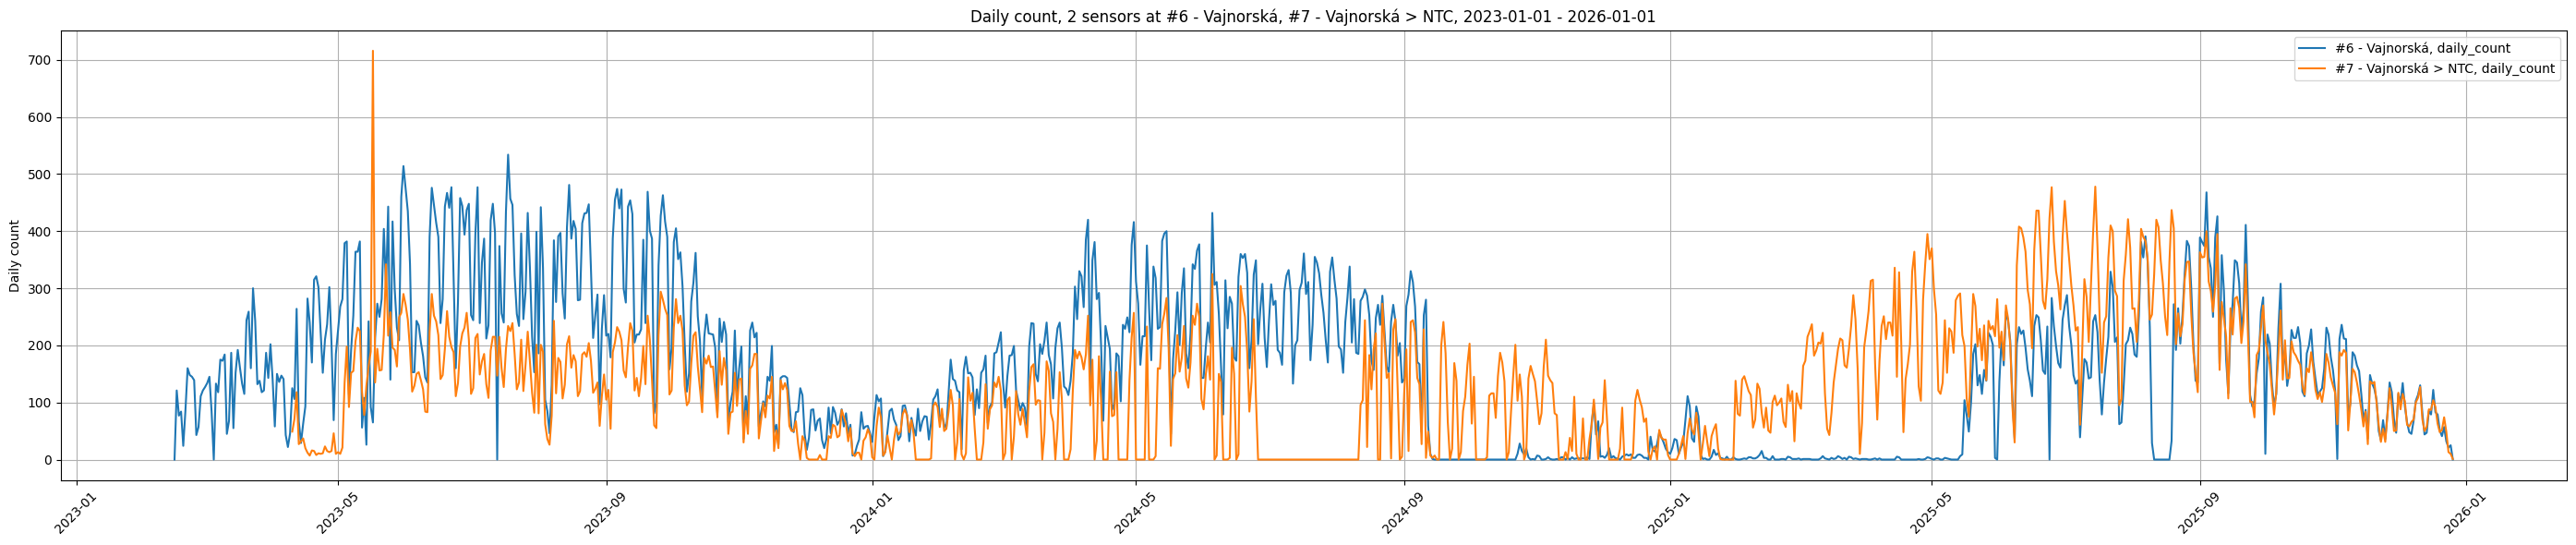

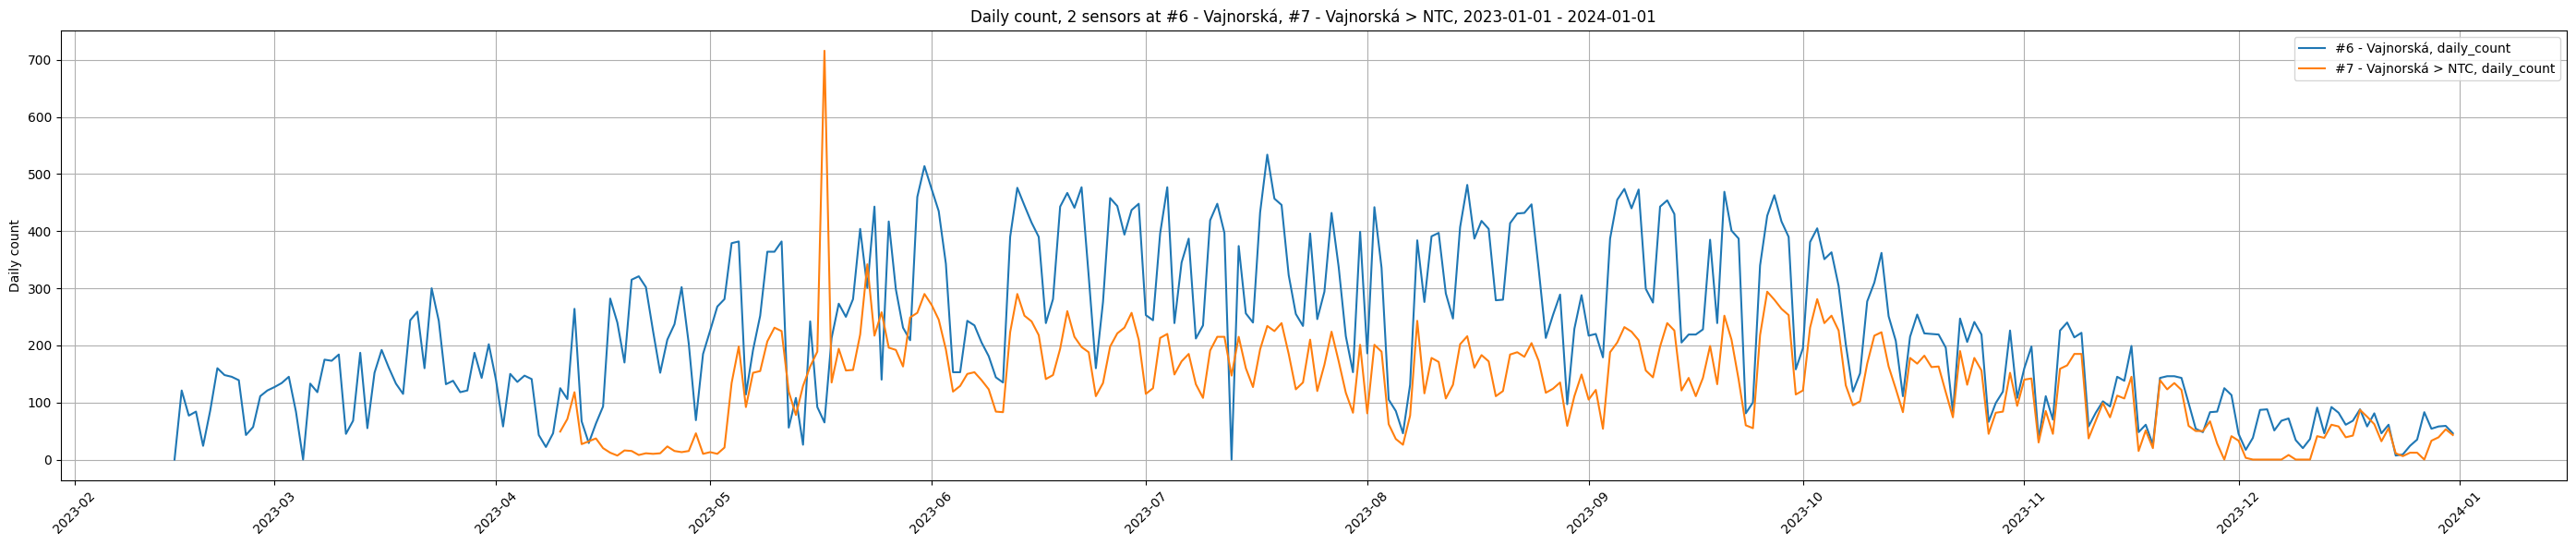

In [279]:
daily_counts = (df.groupby(['nazov', 'date'])['pocet_total'].sum()
    .reset_index(name='daily_count')
)
counter_names = ['#6 - Vajnorská', '#7 - Vajnorská > NTC']
plot_data_at_route(daily_counts, '2023-01-01', '2026-01-01', counter_names, ['daily_count'], 'Daily count')
plot_data_at_route(daily_counts, '2023-01-01', '2024-01-01', counter_names, ['daily_count'], 'Daily count')

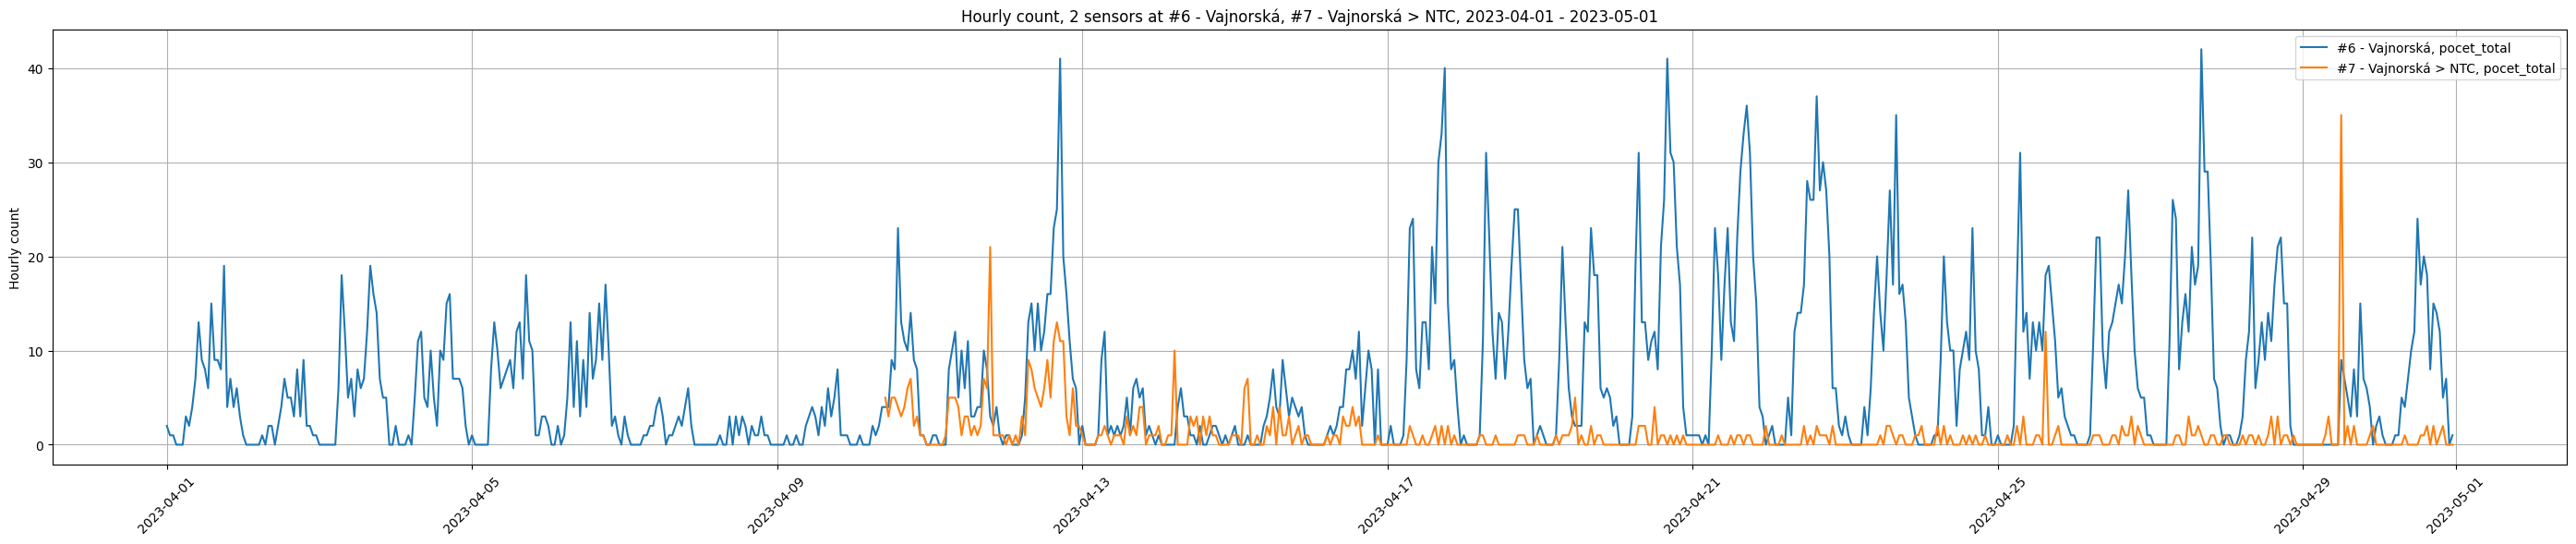

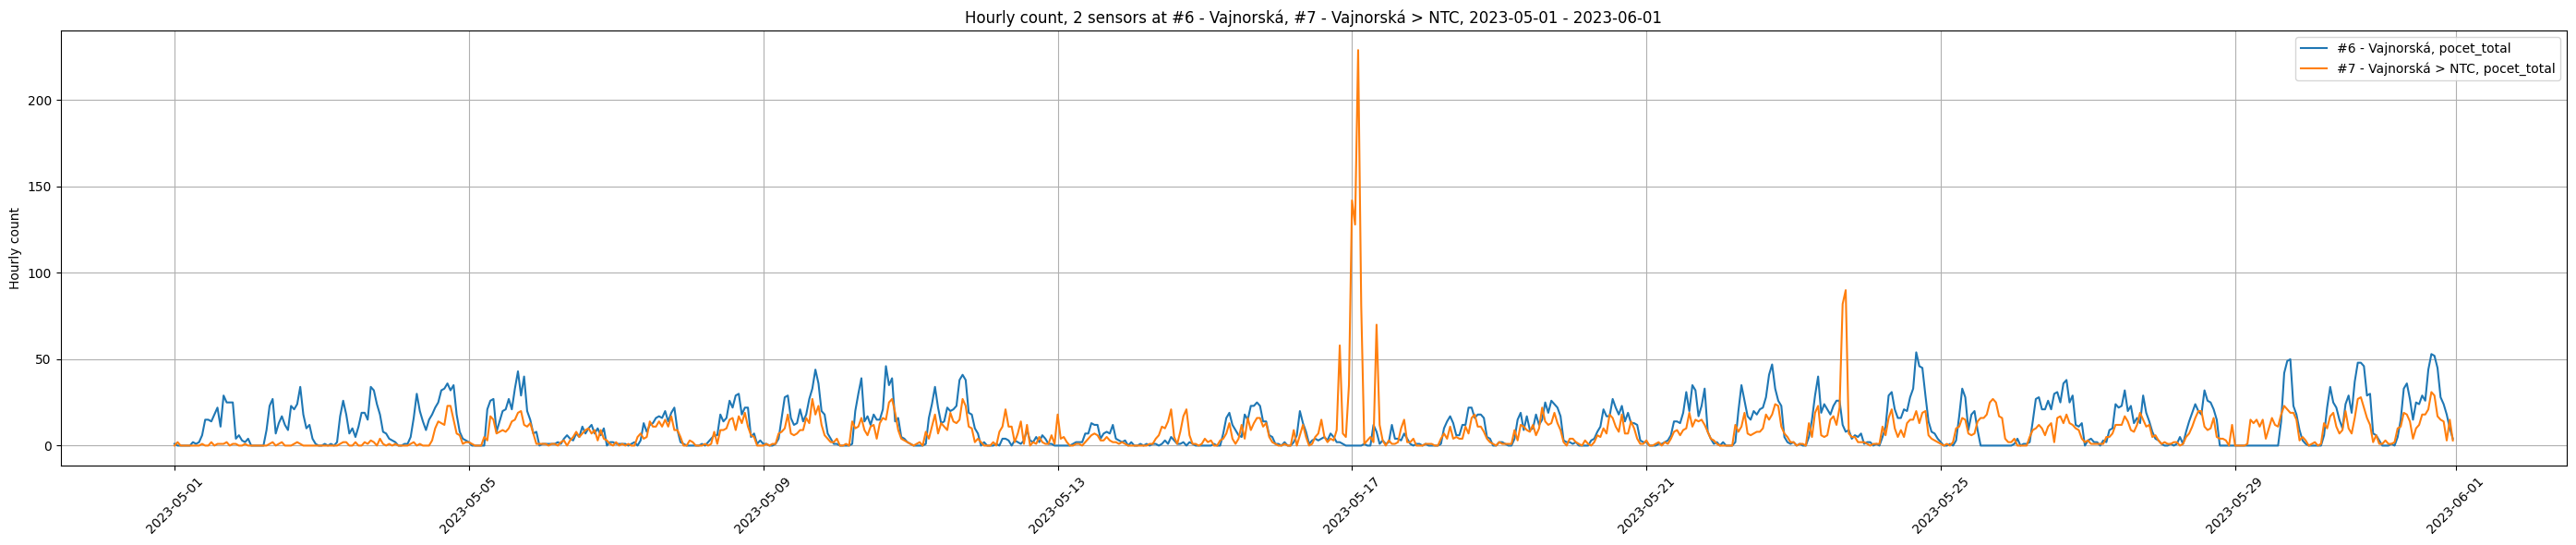

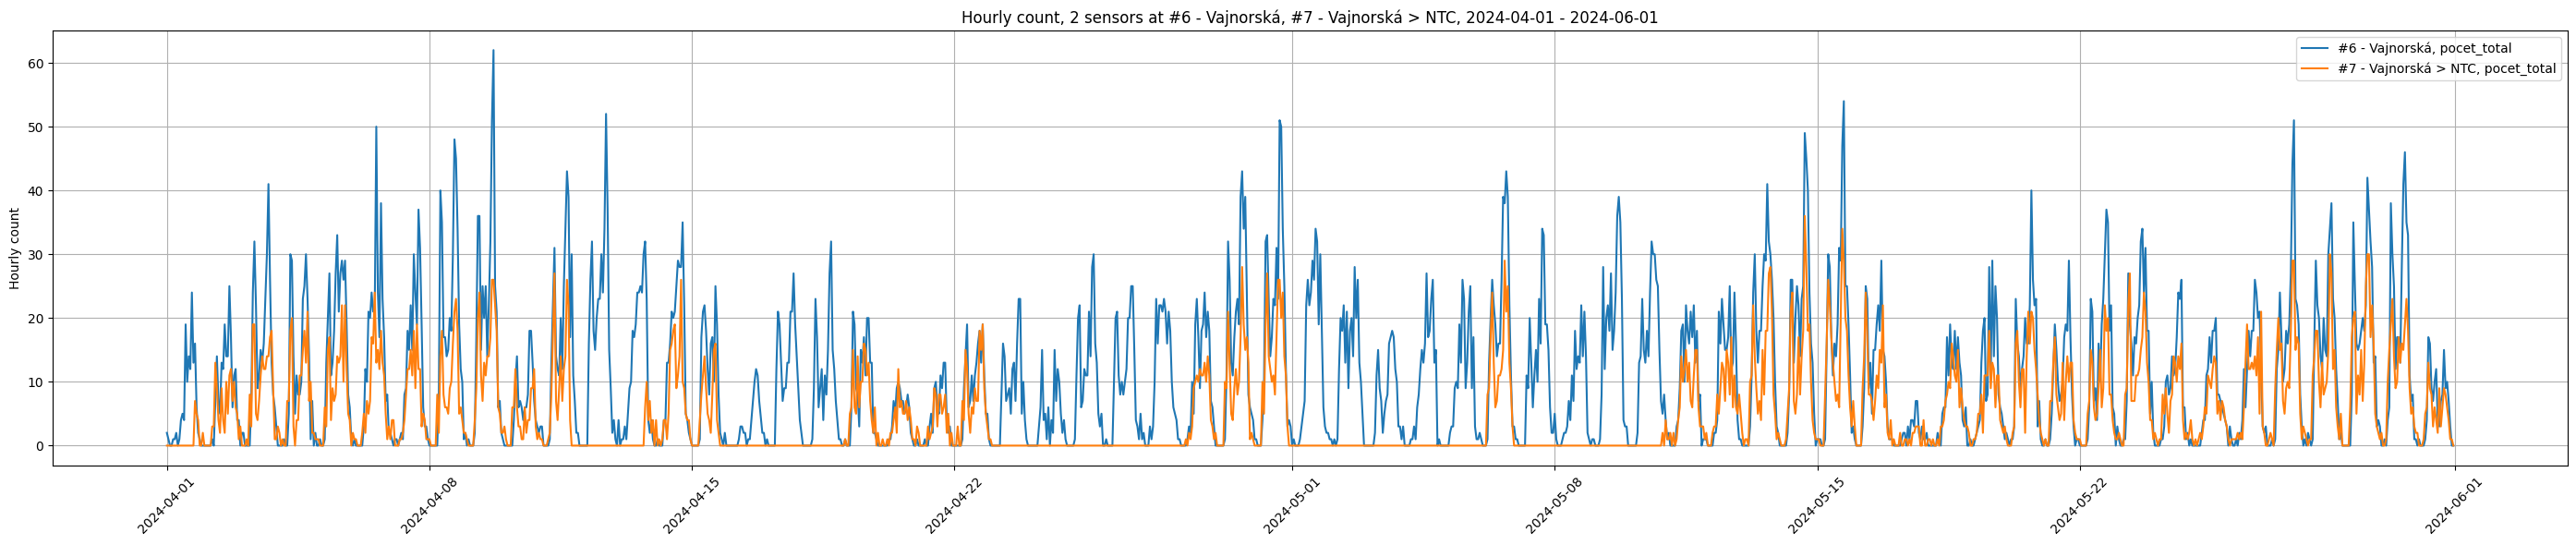

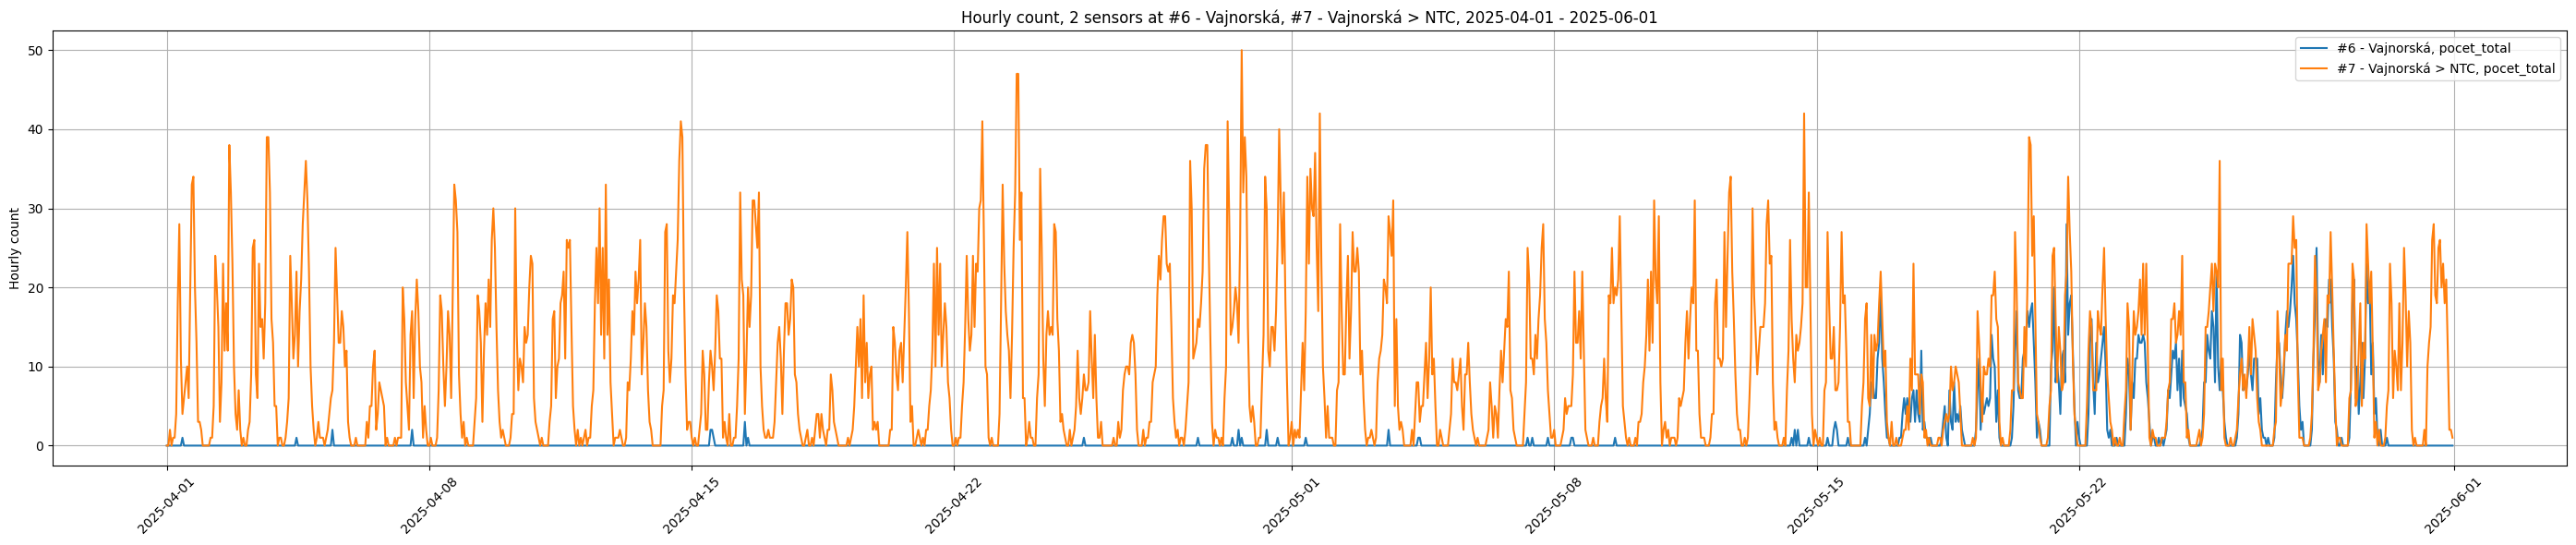

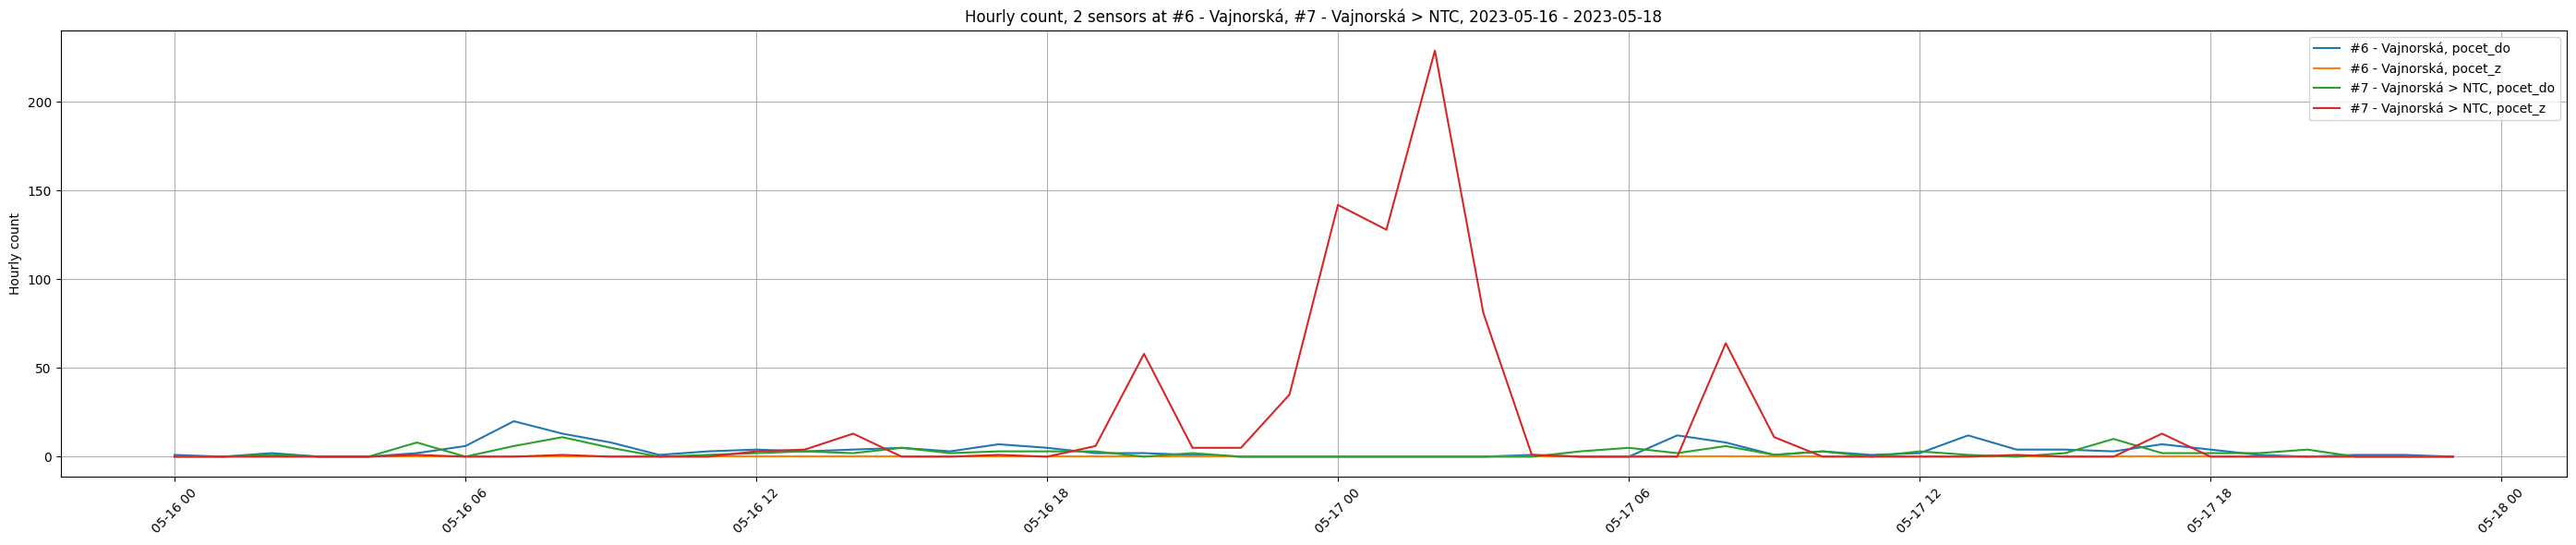

In [280]:
counter_names = ['#6 - Vajnorská', '#7 - Vajnorská > NTC']
y_title = 'Hourly count'
plot_data_at_route(df, '2023-04-01', '2023-05-01', counter_names, ['pocet_total'], y_title)
plot_data_at_route(df, '2023-05-01', '2023-06-01', counter_names, ['pocet_total'], y_title)
plot_data_at_route(df, '2024-04-01', '2024-06-01', counter_names, ['pocet_total'], y_title)
plot_data_at_route(df, '2025-04-01', '2025-06-01', counter_names, ['pocet_total'], y_title)
plot_data_at_route(df, '2023-05-16', '2023-05-18', counter_names, ['pocet_do', 'pocet_z'], y_title)

Na grafoch vyššie si môžeme všimnúť, že sčítače #6 a #7 majú v niektorých časových úsekoch trendy veľmi podobné, na iných zase veľmi odlišné zaznamenané počty, špeciálne napríklad v čase 2024-04-01 až 2024-06-01 sú niektoré úseky zjavne silno korelované, no sú tam aj úseky, kde sčítač #7 nezaznamenal žiadne počty, zatiaľ, čo senzor #6 pokračoval v zaznamenávaní počtov očakávateľných z predchádzajúcich. Podobne aj v grafoch o čase 2023-04-01 až 2023-06-01 sú viaceré úseky, kde sčítač #7 zaznamenal veľmi nízke počty v porovnaní so sčítačom #6. Je tam aj jeden konkrétny čas (0. až 2. hodina 17.5.2023), kedy bol jedným sčítačom zaznamenaný nadštandardne vysoký počet, vyše 200 cyklistov smerom na Kuchajdu. Nepodarilo sa nám nájsť údaje, ktoré by jednoznačne rozhodli, či išlo o naozajstných nočných cyklistov, alebo došlo ku chybe v meraní. Naopak v grafe z času 2025-04-01 až 2025-06-01 sčítač #7 zaznamenával vysoké počty, aké by sa dali očakávať v tomto období roku, zatiaľ čo sčítač #6 mal vačšinu tohto úseku prevažne nulové počty. Z týchto vypozorovaných skutočností sme usúdili, že sšítače sa pravdepodobne snažia merať tých istých cyklistov, ale niekedy v jednom z nich dochádza k poruche a preto nameria výrazne nižší počet. Tieto dáta zlúčime v datasete tak, že pre každý čas s meraním z obidvoch sčítačov zoberieme maximum hodnôt.

In [281]:
vajnorska_mask = df['nazov'].isin(['#6 - Vajnorská', '#7 - Vajnorská > NTC'])
vajnorska_df = df[vajnorska_mask].copy()
agg_strategy = {
    'nazov': lambda x: 'Vajnorská_combined',
    'pocet_do': 'max',
    'pocet_z': 'max',
    'zemepisna_sirka': 'first',
    'zemepisna_dlzka': 'first',
    'smer_do': 'first',
    'smer_z': 'first',
    'datetime': 'first',
    'date': 'first',
    'weekday': 'first',
    'is_weekend': 'first',
    'month': 'first',
    'year': 'first'
}
combined_df = vajnorska_df.groupby('datetime', as_index=False).agg(agg_strategy)
combined_df['pocet_total'] = combined_df['pocet_do'] + combined_df['pocet_z']
combined_df = combined_df[df.columns]
old_df = df.copy()
df = pd.concat([df[~vajnorska_mask], combined_df], ignore_index=True)
print(f"Replaced {vajnorska_mask.sum()} records with {len(combined_df)} combined records")
print(f"Original DF shape: {old_df.shape}, New DF shape: {df.shape}")

Replaced 48814 records with 25050 combined records
Original DF shape: (678931, 14), New DF shape: (655167, 14)


## Zjednotenie na rovnaké časové obdobie

In [282]:
min_dates = df.groupby('nazov')[['date']].min().sort_values('date').reset_index()
max_dates = df.groupby('nazov')[['date']].max().sort_values('date').reset_index()
common_start = pd.to_datetime(min_dates['date'].max())
common_end = pd.to_datetime(max_dates['date'].min())
print(f'From {common_start} to {common_end}: {common_end - common_start}')

From 2025-02-06 00:00:00 to 2025-12-08 00:00:00: 305 days 00:00:00


### Príprava dát pre hypotézu o Vajanského nábreží

In [283]:
min_dates

nazov       date
0           Cyklomost Slobody 2014-07-18
1                 Hradza Berg 2014-11-20
2                   Viedenska 2014-11-22
3           Devinska Nova Ves 2019-10-18
4             #3 - River Park 2022-08-31
5             #1 - Starý Most 2022-08-31
6            #4 - Dolnozemská 2022-09-01
7         #5 - Devínska cesta 2023-02-12
8          Vajnorská_combined 2023-02-15
9               #8 - Most SNP 2023-02-15
10             #9 - Páričkova 2023-02-15
11    #12 - Železná studnička 2023-03-05
12             #10 - Dunajská 2023-03-05
13          #11 - Most Apollo 2023-03-07
14          #2 - Starý most 2 2023-03-26
15        Vajanského_combined 2024-01-26
16  #17 - Dunajská/Lazaretská 2025-02-06
17  #15 - Incheba Einsteinova 2025-02-06
18          #16 - Trenčianska 2025-02-06

Pri príprave dát na analýzu vplyvu otvorenia cyklocesty na Vajanského nábreží (6.9.2023) sme narazili problém, že časť trás (vrátane Vajanského nábrežia) začala používať sčítače až v roku 2024 alebo neskôr. Z tohto dôvodu sme pri tejto analýze vylúčili trasy **Vajanského**, **Dunajská/Lazaretská**, **Incheba Einsteinova** a **Trenčianska**. Tiež sme kvôli zjavnej ročnej periodicite (najviac cyklistov počas leta, najmenej cez zimu) museli zvážiť, ako zvoliť časové úseky na skúmanie, aby tým neboli príliš skreslené výsledky.
Rozhodli sme sa porovnávať priemernú dennú vyťaženosť v mesiacoch september-október v rokoch 2022 a 2023, čo ešte viac obmedzilo množinu trás na: Cyklomost Slobody, Hradza Berg, Viedenska, Devinska Nova Ves, River Park, Starý Most, Dolnozemská.

In [284]:
vajansky_opening = pd.to_datetime('2023-09-06')
start_22 = vajansky_opening - pd.DateOffset(years=1)
end_22 = pd.to_datetime('2022-11-01')
start_23 = vajansky_opening
end_23 = end_22 + pd.DateOffset(years=1)
early_routes = min_dates[min_dates['date'] < start_22]['nazov']

In [285]:
fall_22 = df[df['nazov'].isin(early_routes) & (df['date'] < end_22) & (df['date'] >= start_22)]
fall_23 = df[df['nazov'].isin(early_routes) & (df['date'] < end_23) & (df['date'] >= start_23)]

In [286]:
def daily_aggregate(data):
    daily_data = data.groupby(['nazov', 'date']).agg({
        'pocet_do': 'sum',
        'pocet_z': 'sum',
        'pocet_total': 'sum',
        'datetime': 'count', # how many hours were measured by counter that day
        'zemepisna_sirka': 'first',
        'zemepisna_dlzka': 'first',
        'smer_do': 'first',
        'smer_z': 'first',
        'weekday': 'first',
        'is_weekend': 'first',
        'month': 'first',
        'year': 'first'
    }).reset_index()

    daily_data = daily_data.rename(columns={
        'pocet_do': 'daily_pocet_do',
        'pocet_z': 'daily_pocet_z',
        'pocet_total': 'daily_total',
        'datetime': 'hour_count'
    })
    return daily_data

daily_fall_22 = daily_aggregate(fall_22)
daily_fall_23 = daily_aggregate(fall_23)

In [287]:
daily_fall_22.groupby('hour_count')['nazov'].count()

hour_count
15      1
17      1
20      1
23      1
24    380
Name: nazov, dtype: int64

In [288]:
daily_fall_23.groupby('hour_count')['nazov'].count()

hour_count
23      3
24    383
Name: nazov, dtype: int64

In [289]:
daily_fall_22 = daily_fall_22[daily_fall_22['hour_count'] == 24]
daily_fall_23 = daily_fall_23[daily_fall_23['hour_count'] == 24]
daily_fall = pd.concat([daily_fall_22, daily_fall_23], ignore_index=True)

In [290]:
fall_path = ('' if IN_COLAB else '../Data/') + 'daily_fall_22_23.csv'
daily_fall.to_csv('fall_path', index=False)

### Príprava dát na analýzu dennej vyťaženosti

In [291]:
df = df[(df['date'] > common_start) & (df['date'] < common_end)]
df.describe()

zemepisna_sirka  zemepisna_dlzka       pocet_do        pocet_z  \
count    138153.000000    138153.000000  138153.000000  138153.000000   
mean         48.147868        17.093206      12.121590      10.843413   
min          48.110442        16.969000       0.000000       0.000000   
25%          48.134661        17.073272       0.000000       0.000000   
50%          48.140819        17.116058       2.000000       2.000000   
75%          48.162144        17.127928      14.000000      12.000000   
max          48.210650        17.138556     483.000000     645.000000   
std           0.024772         0.051781      23.960382      23.082728   

                            datetime    pocet_total  \
count                         138153  138153.000000   
mean   2025-07-09 02:55:47.731862528      22.965003   
min              2025-02-07 00:00:00       0.000000   
25%              2025-04-24 07:00:00       0.000000   
50%              2025-07-09 03:00:00       6.000000   
75%              2025-09-23 03:00:00      29.000000   
max              2025-12-07 23:00:00     852.000000   
std                              NaN      42.255563   

                                date        weekday     is_weekend  \
count                         138153  138153.000000  138153.000000   
mean   2025-07-08 15:25:49.334433536       3.020962       0.289947   
min              2025-02-07 00:00:00       0.000000       0.000000   
25%              2025-04-24 00:00:00       1.000000       0.000000   
50%              2025-07-09 00:00:00       3.000000       0.000000   
75%              2025-09-23 00:00:00       5.000000       1.000000   
max              2025-12-07 00:00:00       6.000000       1.000000   
std                              NaN       2.001757       0.453739   

               month      year  
count  138153.000000  138153.0  
mean        6.752029    2025.0  
min         2.000000    2025.0  
25%         4.000000    2025.0  
50%         7.000000    2025.0  
75%         9.000000    2025.0  
max        12.000000    2025.0  
std         2.886574       0.0

In [292]:
daily_counts = daily_aggregate(df)

column_order = [
    'nazov', 'date', 'hour_count',
    'daily_pocet_do', 'daily_pocet_z', 'daily_total',
    'zemepisna_sirka', 'zemepisna_dlzka',
    'smer_do', 'smer_z',
    'weekday', 'is_weekend', 'month', 'year'
]
daily_df = daily_counts[column_order].copy()

print(f"Original hourly shape: {df.shape}")
print(f"Daily aggregates shape: {daily_counts.shape}")
print(f"Sample daily data for Vajnorská:")
display(daily_df[daily_df['nazov'] == 'Vajnorská_combined'].head(3))

Original hourly shape: (138153, 14)
Daily aggregates shape: (5760, 14)
Sample daily data for Vajnorská:


nazov       date  hour_count  daily_pocet_do  \
5155  Vajnorská_combined 2025-02-07          24             106   
5156  Vajnorská_combined 2025-02-08          24              51   
5157  Vajnorská_combined 2025-02-09          24              63   

      daily_pocet_z  daily_total  zemepisna_sirka  zemepisna_dlzka  \
5155              9          115        48.162144        17.131644   
5156              5           56        48.162144        17.131644   
5157              7           70        48.162144        17.131644   

                      smer_do    smer_z  weekday  is_weekend  month  year  
5155  Trnavské mýto (Centrum)  Kuchajda        4           0      2  2025  
5156  Trnavské mýto (Centrum)  Kuchajda        5           1      2  2025  
5157  Trnavské mýto (Centrum)  Kuchajda        6           1      2  2025

### Neúplné záznamy z dní, čo s nimi?

Pre dni a sčítače, kde chýba niekoľko hodinových meraní väčšinou chýba <= 5 záznamov, ale v jednom prípade chýba 19 záznamov. Taký problém má 7 dní.
Pre dni, kedy chýbajú záznamy z celého dňa pre nejaký sčítač, vždy chýba iba jeden sčítač, takých je 16 dátumov. Najviac (8) dní meraní chýba v Devinskej Novej Vsi, 3 na Cyklomoste Slobody a Viedenskej, 2 na Hrádzi Berg.

In [293]:
incomplete_days = daily_df[daily_df['hour_count'] < 24]
incomplete_days.groupby('hour_count')['nazov'].count().reset_index(name='incomplete_days_frequency')

hour_count  incomplete_days_frequency
0           5                          1
1          19                          1
2          21                          3
3          22                          6
4          23                         42

In [294]:
incomplete_dates = set(incomplete_days['date'])
incomplete_dates

{Timestamp('2025-03-30 00:00:00'),
 Timestamp('2025-08-28 00:00:00'),
 Timestamp('2025-10-22 00:00:00'),
 Timestamp('2025-10-26 00:00:00'),
 Timestamp('2025-10-27 00:00:00'),
 Timestamp('2025-11-23 00:00:00'),
 Timestamp('2025-11-24 00:00:00')}

In [295]:
counters_on_days = (daily_df.groupby('date')['nazov'].count()
                 .reset_index(name='counter_count'))
missing_days = counters_on_days[counters_on_days['counter_count'] < 19]
missing_days

date  counter_count
10  2025-02-17             18
12  2025-02-19             18
17  2025-02-24             18
19  2025-02-26             18
40  2025-03-19             18
42  2025-03-21             18
47  2025-03-26             18
49  2025-03-28             18
70  2025-04-18             18
72  2025-04-20             18
143 2025-06-30             18
144 2025-07-01             18
158 2025-07-15             18
174 2025-07-31             18
182 2025-08-08             18
194 2025-08-20             18

In [296]:
missing_dates = set(missing_days['date'])
len(missing_dates), missing_dates

(16,
 {Timestamp('2025-02-17 00:00:00'),
  Timestamp('2025-02-19 00:00:00'),
  Timestamp('2025-02-24 00:00:00'),
  Timestamp('2025-02-26 00:00:00'),
  Timestamp('2025-03-19 00:00:00'),
  Timestamp('2025-03-21 00:00:00'),
  Timestamp('2025-03-26 00:00:00'),
  Timestamp('2025-03-28 00:00:00'),
  Timestamp('2025-04-18 00:00:00'),
  Timestamp('2025-04-20 00:00:00'),
  Timestamp('2025-06-30 00:00:00'),
  Timestamp('2025-07-01 00:00:00'),
  Timestamp('2025-07-15 00:00:00'),
  Timestamp('2025-07-31 00:00:00'),
  Timestamp('2025-08-08 00:00:00'),
  Timestamp('2025-08-20 00:00:00')})

In [297]:
full_date_range = pd.date_range(start=(common_start + pd.DateOffset(1)).date(),
                                end=(common_end - pd.DateOffset(1)).date(), freq='D')
full_date_range

DatetimeIndex(['2025-02-07', '2025-02-08', '2025-02-09', '2025-02-10',
               '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14',
               '2025-02-15', '2025-02-16',
               ...
               '2025-11-28', '2025-11-29', '2025-11-30', '2025-12-01',
               '2025-12-02', '2025-12-03', '2025-12-04', '2025-12-05',
               '2025-12-06', '2025-12-07'],
              dtype='datetime64[ns]', length=304, freq='D')

V datasete nie sú žiadne dni z daného spoločného rozsahu, pre ktoré by nemal záznam žiaden sčítač.

In [298]:
set(full_date_range) - set(counters_on_days['date'])

set()

In [299]:
from collections import defaultdict

all_counters = set(df['nazov'].unique())
missing_days_routes = defaultdict(list)
for date in missing_dates:
    print(date)
    diff = all_counters - set(df[df['date'] == date]['nazov'].unique())
    display(diff)
    for x in diff:
        missing_days_routes[x].append(date)

2025-02-24 00:00:00


{'Hradza Berg'}

2025-03-19 00:00:00


{'Devinska Nova Ves'}

2025-07-31 00:00:00


{'Viedenska'}

2025-02-17 00:00:00


{'Devinska Nova Ves'}

2025-03-21 00:00:00


{'Cyklomost Slobody'}

2025-03-26 00:00:00


{'Hradza Berg'}

2025-08-08 00:00:00


{'Devinska Nova Ves'}

2025-03-28 00:00:00


{'Viedenska'}

2025-08-20 00:00:00


{'Devinska Nova Ves'}

2025-02-19 00:00:00


{'Cyklomost Slobody'}

2025-06-30 00:00:00


{'Devinska Nova Ves'}

2025-04-20 00:00:00


{'Cyklomost Slobody'}

2025-04-18 00:00:00


{'Devinska Nova Ves'}

2025-07-01 00:00:00


{'Devinska Nova Ves'}

2025-07-15 00:00:00


{'Devinska Nova Ves'}

2025-02-26 00:00:00


{'Viedenska'}

In [300]:
from pprint import pprint
pprint(missing_days_routes)

defaultdict(<class 'list'>,
            {'Cyklomost Slobody': [Timestamp('2025-03-21 00:00:00'),
                                   Timestamp('2025-02-19 00:00:00'),
                                   Timestamp('2025-04-20 00:00:00')],
             'Devinska Nova Ves': [Timestamp('2025-03-19 00:00:00'),
                                   Timestamp('2025-02-17 00:00:00'),
                                   Timestamp('2025-08-08 00:00:00'),
                                   Timestamp('2025-08-20 00:00:00'),
                                   Timestamp('2025-06-30 00:00:00'),
                                   Timestamp('2025-04-18 00:00:00'),
                                   Timestamp('2025-07-01 00:00:00'),
                                   Timestamp('2025-07-15 00:00:00')],
             'Hradza Berg': [Timestamp('2025-02-24 00:00:00'),
                             Timestamp('2025-03-26 00:00:00')],
             'Viedenska': [Timestamp('2025-07-31 00:00:00'),
                       

In [301]:
dates_to_remove = missing_dates.union(incomplete_dates)
len(dates_to_remove)

23

In [302]:
den_nazov = {
    0: 'pondelok',
    1: 'utorok',
    2: 'streda',
    3: 'štvrtok',
    4: 'piatok',
    5: 'sobota',
    6: 'nedeľa'
}
nazov_den = {v: k for k, v in den_nazov.items()}
day_counts = defaultdict(int)
for date in sorted(dates_to_remove):
    day_name = den_nazov[date.dayofweek]
    day_counts[date.dayofweek] += 1
    print(f'{date.date()}: {day_name}, {date.weekofyear}. týžďeň')

sum_of_all = sum(day_counts.values())
sum_of_weekends = 0
for k, v in sorted(day_counts.items()):
    if k in [5, 6]:
        sum_of_weekends += v
    print(f'{den_nazov[k]}: {v}')
ratio = sum_of_weekends / sum_of_all * 100
print(f'{sum_of_weekends} víkendových dní z {sum_of_all} odstránených dní ({ratio:.2f} %)')

2025-02-17: pondelok, 8. týžďeň
2025-02-19: streda, 8. týžďeň
2025-02-24: pondelok, 9. týžďeň
2025-02-26: streda, 9. týžďeň
2025-03-19: streda, 12. týžďeň
2025-03-21: piatok, 12. týžďeň
2025-03-26: streda, 13. týžďeň
2025-03-28: piatok, 13. týžďeň
2025-03-30: nedeľa, 13. týžďeň
2025-04-18: piatok, 16. týžďeň
2025-04-20: nedeľa, 16. týžďeň
2025-06-30: pondelok, 27. týžďeň
2025-07-01: utorok, 27. týžďeň
2025-07-15: utorok, 29. týžďeň
2025-07-31: štvrtok, 31. týžďeň
2025-08-08: piatok, 32. týžďeň
2025-08-20: streda, 34. týžďeň
2025-08-28: štvrtok, 35. týžďeň
2025-10-22: streda, 43. týžďeň
2025-10-26: nedeľa, 43. týžďeň
2025-10-27: pondelok, 44. týžďeň
2025-11-23: nedeľa, 47. týžďeň
2025-11-24: pondelok, 48. týžďeň
pondelok: 5
utorok: 2
streda: 6
štvrtok: 2
piatok: 4
nedeľa: 4
4 víkendových dní z 23 odstránených dní (17.39 %)


Dni s chýbajúcimi údajmi majú pomerne dobrú distribúciu v rámci týždňov aj mesiacov, preto sa nemusíme báť, že ich odstránením by sme priniesli do dát vážne predsudky.

In [303]:
final_daily = daily_df[~daily_df['date'].isin(dates_to_remove)]
final_daily

nazov       date  hour_count  daily_pocet_do  daily_pocet_z  \
0     #1 - Starý Most 2025-02-07          24             172             28   
1     #1 - Starý Most 2025-02-08          24             102             11   
2     #1 - Starý Most 2025-02-09          24             124             25   
3     #1 - Starý Most 2025-02-10          24             203             43   
4     #1 - Starý Most 2025-02-11          24             195             43   
...               ...        ...         ...             ...            ...   
5755        Viedenska 2025-12-03          24               3            129   
5756        Viedenska 2025-12-04          24               2            104   
5757        Viedenska 2025-12-05          24               1             58   
5758        Viedenska 2025-12-06          24               9            121   
5759        Viedenska 2025-12-07          24               8            189   

      daily_total  zemepisna_sirka  zemepisna_dlzka          smer_do  \
0             200        48.110442        17.127512          Centrum   
1             113        48.110442        17.127512          Centrum   
2             149        48.110442        17.127512          Centrum   
3             246        48.110442        17.127512          Centrum   
4             238        48.110442        17.127512          Centrum   
...           ...              ...              ...              ...   
5755          132        48.136692        17.106380  k Staremu mostu   
5756          106        48.136692        17.106380  k Staremu mostu   
5757           59        48.136692        17.106380  k Staremu mostu   
5758          130        48.136692        17.106380  k Staremu mostu   
5759          197        48.136692        17.106380  k Staremu mostu   

           smer_z  weekday  is_weekend  month  year  
0       Petržalka        4           0      2  2025  
1       Petržalka        5           1      2  2025  
2       Petržalka        6           1      2  2025  
3       Petržalka        0           0      2  2025  
4       Petržalka        1           0      2  2025  
...           ...      ...         ...    ...   ...  
5755  k Mostu SNP        2           0     12  2025  
5756  k Mostu SNP        3           0     12  2025  
5757  k Mostu SNP        4           0     12  2025  
5758  k Mostu SNP        5           1     12  2025  
5759  k Mostu SNP        6           1     12  2025  

[5339 rows x 14 columns]

In [304]:
final_daily.describe()

date  hour_count  daily_pocet_do  \
count                           5339      5339.0     5339.000000   
mean   2025-07-10 06:39:42.918149632        24.0      292.546170   
min              2025-02-07 00:00:00        24.0        0.000000   
25%              2025-04-29 00:00:00        24.0       65.000000   
50%              2025-07-10 00:00:00        24.0      189.000000   
75%              2025-09-23 00:00:00        24.0      396.000000   
max              2025-12-07 00:00:00        24.0     3390.000000   
std                              NaN         0.0      326.438066   

       daily_pocet_z  daily_total  zemepisna_sirka  zemepisna_dlzka  \
count    5339.000000  5339.000000      5339.000000      5339.000000   
mean      263.010114   555.556284        48.147953        17.092979   
min         0.000000     0.000000        48.110442        16.969000   
25%        44.000000   181.000000        48.134661        17.073272   
50%       163.000000   394.000000        48.140819        17.116058   
75%       353.000000   756.000000        48.162144        17.127928   
max      3453.000000  6843.000000        48.210650        17.138556   
std       324.599192   580.307931         0.024853         0.051982   

           weekday   is_weekend        month    year  
count  5339.000000  5339.000000  5339.000000  5339.0  
mean      3.053381     0.298932     6.822064  2025.0  
min       0.000000     0.000000     2.000000  2025.0  
25%       1.000000     0.000000     4.000000  2025.0  
50%       3.000000     0.000000     7.000000  2025.0  
75%       5.000000     1.000000     9.000000  2025.0  
max       6.000000     1.000000    12.000000  2025.0  
std       1.995019     0.457833     2.851940     0.0

In [305]:
final_daily = final_daily.drop(columns=['hour_count'])

In [306]:
final_hourly = df[~df['date'].isin(dates_to_remove)]
final_hourly

nazov  zemepisna_sirka  zemepisna_dlzka  \
0        #11 - Most Apollo        48.134661        17.127928   
1        #11 - Most Apollo        48.134661        17.127928   
2        #11 - Most Apollo        48.134661        17.127928   
3        #11 - Most Apollo        48.134661        17.127928   
4        #11 - Most Apollo        48.134661        17.127928   
...                    ...              ...              ...   
654729  Vajnorská_combined        48.162144        17.131644   
654730  Vajnorská_combined        48.162144        17.131644   
654731  Vajnorská_combined        48.162144        17.131644   
654732  Vajnorská_combined        48.162144        17.131644   
654733  Vajnorská_combined        48.162144        17.131644   

                        smer_do     smer_z  pocet_do  pocet_z  \
0                       Centrum  Petržalka         0        0   
1                       Centrum  Petržalka         0        0   
2                       Centrum  Petržalka         0        0   
3                       Centrum  Petržalka         0        0   
4                       Centrum  Petržalka         0        0   
...                         ...        ...       ...      ...   
654729  Trnavské mýto (Centrum)   Kuchajda         4        1   
654730  Trnavské mýto (Centrum)   Kuchajda         3        0   
654731  Trnavské mýto (Centrum)   Kuchajda         0        0   
654732  Trnavské mýto (Centrum)   Kuchajda         0        0   
654733  Trnavské mýto (Centrum)   Kuchajda         0        0   

                  datetime  pocet_total       date  weekday  is_weekend  \
0      2025-04-23 01:00:00            0 2025-04-23        2           0   
1      2025-04-23 00:00:00            0 2025-04-23        2           0   
2      2025-04-22 23:00:00            0 2025-04-22        1           0   
3      2025-04-22 22:00:00            0 2025-04-22        1           0   
4      2025-04-22 21:00:00            0 2025-04-22        1           0   
...                    ...          ...        ...      ...         ...   
654729 2025-12-07 19:00:00            5 2025-12-07        6           1   
654730 2025-12-07 20:00:00            3 2025-12-07        6           1   
654731 2025-12-07 21:00:00            0 2025-12-07        6           1   
654732 2025-12-07 22:00:00            0 2025-12-07        6           1   
654733 2025-12-07 23:00:00            0 2025-12-07        6           1   

        month  year  
0           4  2025  
1           4  2025  
2           4  2025  
3           4  2025  
4           4  2025  
...       ...   ...  
654729     12  2025  
654730     12  2025  
654731     12  2025  
654732     12  2025  
654733     12  2025  

[128136 rows x 14 columns]

In [307]:
final_hourly.describe()

zemepisna_sirka  zemepisna_dlzka       pocet_do        pocet_z  \
count    128136.000000    128136.000000  128136.000000  128136.000000   
mean         48.147953        17.092979      12.189424      10.958755   
min          48.110442        16.969000       0.000000       0.000000   
25%          48.134661        17.073272       0.000000       0.000000   
50%          48.140819        17.116058       2.000000       2.000000   
75%          48.162144        17.127928      14.000000      12.000000   
max          48.210650        17.138556     483.000000     645.000000   
std           0.024851         0.051978      24.066597      23.252578   

                            datetime    pocet_total  \
count                         128136  128136.000000   
mean   2025-07-10 18:09:42.918149632      23.148178   
min              2025-02-07 00:00:00       0.000000   
25%              2025-04-29 05:45:00       0.000000   
50%              2025-07-10 11:30:00       6.000000   
75%              2025-09-23 17:15:00      29.000000   
max              2025-12-07 23:00:00     852.000000   
std                              NaN      42.480420   

                                date        weekday     is_weekend  \
count                         128136  128136.000000  128136.000000   
mean   2025-07-10 06:39:42.918149376       3.053381       0.298932   
min              2025-02-07 00:00:00       0.000000       0.000000   
25%              2025-04-29 00:00:00       1.000000       0.000000   
50%              2025-07-10 00:00:00       3.000000       0.000000   
75%              2025-09-23 00:00:00       5.000000       1.000000   
max              2025-12-07 00:00:00       6.000000       1.000000   
std                              NaN       1.994840       0.457792   

               month      year  
count  128136.000000  128136.0  
mean        6.822064    2025.0  
min         2.000000    2025.0  
25%         4.000000    2025.0  
50%         7.000000    2025.0  
75%         9.000000    2025.0  
max        12.000000    2025.0  
std         2.851684       0.0

In [308]:
hourly_path = ('' if IN_COLAB else '../Data/') + 'hourly_strict.csv'
final_hourly.to_csv(hourly_path, index=False)
daily_path = ('' if IN_COLAB else '../Data/') + 'daily_strict.csv'
final_daily.to_csv(daily_path, index=False)